In [2]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 8.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from IPython.display import HTML as html_print
from termcolor import colored
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="scipy")
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
df = pd.read_csv("/content/veri_seti_son_2.csv")

In [7]:
def print_section_title(title):
    print(colored(title, 'blue', attrs=['bold', 'underline']))

def display_head_and_tail(dataframe, head=5):
    display(dataframe.head(head).style.set_caption("Head"))
    display(dataframe.tail(head).style.set_caption("Tail"))

def display_na(dataframe):
    na_df = dataframe.isnull().sum().reset_index()
    na_df.columns = ['Column', 'Number of NA']
    display(na_df.style.set_caption("Number of NA Values"))

def display_quantiles(dataframe):
    quantiles_df = dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T
    display(quantiles_df.style.format("{:.2f}").set_caption("Quantiles"))

def check_df(dataframe, head=5):
    print_section_title('Shape')
    print(dataframe.shape)
    print_section_title('Types')
    print(dataframe.dtypes.to_frame('Data Type').style.set_caption("Data Types"))
    print_section_title('Info')
    print(dataframe.info())
    print_section_title('Head & Tail')
    display_head_and_tail(dataframe, head)
    print_section_title('NA Values')
    display_na(dataframe)
    print_section_title('Quantiles')
    display_quantiles(dataframe)

In [8]:
check_df(df)

Shape
(491, 29)
Types
Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Project Name                            491 non-null    object 
 1   Project Type                            491 non-null    object 
 2   City                                    491 non-null    object 
 3   County                                  491 non-null    object 
 4   State                                   491 non-null    object 
 5   Digester Type                           491 non-null    object 
 6   Status                                  491 non-null    object 
 7   Year Operational                        491 non-null    float64
 8   Animal/Farm Type(s)                     491 non-null    object 
 9   Cattle                                  491 non-null    float64
 10  Dairy                              

,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,Dairy,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),LCFS Pathway?,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?,Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency
0,Cargill - Sandy River Farm Digester,Farm Scale,Morrilton,Conway,Arkansas,Covered Lagoon,Operational,2008.000000,Swine,0.000000,0.000000,0.000000,4200.000000,No-Info,1814400.000000,0.000000,Flared Full-time,No-Info,No-Info,4482.755303,No-Info,15.000000,4200.000000,432.000000,298.850354,0.000000,21000.000000,86.400000,0.000000
1,Butterfield RNG Digester,Farm Scale,Buckeye,Maricopa,Arizona,Mixed Plug Flow,Operational,2022.000000,Dairy,0.000000,11760.000000,0.000000,0.000000,No-Info,109486.000000,389698.200000,Pipeline Gas,No-Info,Yes,14030.128975,Yes,1.000000,11760.000000,9.310034,14030.128975,3.559343,399840.000000,0.273825,0.974635
2,Caballero Dairy Farms Digester,Farm Scale,Eloy,Pinal,Arizona,Unknown or Unspecified,Construction,2022.000000,Dairy,0.000000,8800.000000,0.000000,0.000000,No-Info,94500.000000,2813080.400000,Pipeline Gas,No-Info,No-Info,98999.890159,No-Info,1.000000,8800.000000,10.738636,98999.890159,29.768047,299200.000000,0.315842,9.402007
3,Green Gas Partners Stanfield Digester,Centralized/Regional,Maricopa,Pinal,Arizona,Complete Mix,Operational,2018.000000,Dairy,0.000000,30000.000000,0.000000,0.000000,No-Info,3454500.000000,2760336.000000,Pipeline Gas,No-Info,Yes,337499.625540,No-Info,5.000000,30000.000000,115.150000,67499.925108,0.799055,1020000.000000,3.386765,2.706212
4,Paloma Dairy Digester,Farm Scale,Gila Bend,Maricopa,Arizona,Complete Mix,Operational,2021.000000,Dairy,0.000000,10000.000000,0.000000,0.000000,No-Info,852545.200000,0.000000,CNG,No-Info,Yes,100569.493399,No-Info,2.000000,10000.000000,85.254520,50284.746699,0.000000,340000.000000,2.507486,0.000000


,Project Name,Project Type,City,County,State,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,Dairy,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),LCFS Pathway?,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?,Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency
486,Quantum Dairy Digester,Farm Scale,Weyauwega,Waupaca,Wisconsin,Mixed Plug Flow,Shut down,2005.000000,Dairy,0.000000,1200.000000,0.000000,0.000000,No-Info,356020.000000,3350700.000000,Cogeneration,No-Info,Yes,45346.436601,Yes,18.000000,1200.000000,296.683333,2519.246478,9.411550,40800.000000,8.725980,82.125000
487,Stencil Farm Digester,Farm Scale,Denmark,Brown,Wisconsin,Horizontal Plug Flow,Shut down,2002.000000,Dairy,0.000000,1000.000000,0.000000,0.000000,No-Info,310865.600000,946080.000000,Electricity,No-Info,Yes,50391.122119,No-Info,21.000000,1000.000000,310.865600,2399.577244,3.043373,34000.000000,9.143106,27.825882
488,Tinedale Farms Digester,Farm Scale,Wrightstown,Jackson,Wisconsin,Fixed Film/Attached Media,Shut down,1999.000000,Dairy,0.000000,1800.000000,0.000000,0.000000,No-Info,200000.000000,5584500.000000,Electricity; Boiler/Furnace fuel,No-Info,No-Info,46163.455081,No-Info,24.000000,1800.000000,111.111111,1923.477295,27.922500,61200.000000,3.267974,91.250000
489,USEMCO - Peters Farm Digester,Farm Scale,Chaseburg,Vernon,Wisconsin,Complete Mix,Shut down,2011.000000,Dairy,0.000000,200.000000,0.000000,0.000000,Yes,23000.000000,3206160.000000,Electricity,No-Info,Yes,91464.824612,No-Info,12.000000,200.000000,115.000000,7622.068718,139.398261,6800.000000,3.382353,471.494118
490,Wyoming Premium Farms 2 Digester,Farm Scale,Wheatland,Platte,Wyoming,Complete Mix,Shut down,2004.000000,Swine,0.000000,0.000000,0.000000,18000.000000,No-Info,445540.000000,1340280.000000,Electricity,No-Info,No-Info,30798.542361,No-Info,19.000000,18000.000000,24.752222,1620.975914,3.008215,90000.000000,4.950444,14.892000


NA Values


,Column,Number of NA
0,Project Name,0
1,Project Type,0
2,City,0
3,County,0
4,State,0
5,Digester Type,0
6,Status,0
7,Year Operational,0
8,Animal/Farm Type(s),0
9,Cattle,0


Quantiles


,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
Year Operational,491.00,2012.57,8.77,1972.00,1972.00,1998.00,2012.00,2023.00,2025.00,2025.00,2025.00
Cattle,491.00,183.52,2237.16,0.00,0.00,0.00,0.00,0.00,2700.00,40000.00,40000.00
Dairy,491.00,3543.31,4984.93,0.00,0.00,0.00,2000.00,10375.00,30250.00,39000.00,39000.00
Poultry,491.00,6087.58,61662.90,0.00,0.00,0.00,0.00,0.00,132000.00,1200000.00,1200000.00
Swine,491.00,2969.49,17713.66,0.00,0.00,0.00,0.00,9696.00,80050.00,239200.00,239200.00
Biogas Generation Estimate (cu-ft/day),491.00,443918.46,414336.11,5000.00,5000.00,33692.50,344690.00,1017422.60,1817830.00,3454500.00,3454500.00
Electricity Generated (kWh/yr),491.00,2218724.16,4487113.72,0.00,0.00,0.00,756437.80,8216981.40,16276400.00,70364700.00,70364700.00
Total Emission Reductions (MTCO2e/yr),491.00,38377.98,45532.72,4.22,4.22,2018.51,24094.43,103921.22,255068.93,390000.01,390000.01
Operational Years,491.00,10.49,8.69,0.00,0.00,0.00,11.00,25.00,41.00,51.00,51.00
Total_Animals,491.00,12783.90,63625.76,10.00,10.00,350.00,3157.00,34000.00,166000.00,1200000.00,1200000.00


In [9]:
drop_columns_new=["Project Name", "City", "County", "State"]

In [10]:
df.drop(drop_columns_new, axis =1, inplace=True)

In [11]:
df.head()

,Project Type,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,Dairy,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),LCFS Pathway?,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?,Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency
0,Farm Scale,Covered Lagoon,Operational,2008.000,Swine,0.000,0.000,0.000,4200.000,No-Info,1814400.000,0.000,Flared Full-time,No-Info,No-Info,4482.755,No-Info,15.000,4200.000,432.000,298.850,0.000,21000.000,86.400,0.000
1,Farm Scale,Mixed Plug Flow,Operational,2022.000,Dairy,0.000,11760.000,0.000,0.000,No-Info,109486.000,389698.200,Pipeline Gas,No-Info,Yes,14030.129,Yes,1.000,11760.000,9.310,14030.129,3.559,399840.000,0.274,0.975
2,Farm Scale,Unknown or Unspecified,Construction,2022.000,Dairy,0.000,8800.000,0.000,0.000,No-Info,94500.000,2813080.400,Pipeline Gas,No-Info,No-Info,98999.890,No-Info,1.000,8800.000,10.739,98999.890,29.768,299200.000,0.316,9.402
3,Centralized/Regional,Complete Mix,Operational,2018.000,Dairy,0.000,30000.000,0.000,0.000,No-Info,3454500.000,2760336.000,Pipeline Gas,No-Info,Yes,337499.626,No-Info,5.000,30000.000,115.150,67499.925,0.799,1020000.000,3.387,2.706
4,Farm Scale,Complete Mix,Operational,2021.000,Dairy,0.000,10000.000,0.000,0.000,No-Info,852545.200,0.000,CNG,No-Info,Yes,100569.493,No-Info,2.000,10000.000,85.255,50284.747,0.000,340000.000,2.507,0.000


In [12]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

    Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
    Note Categorical variables include categorical variables with numeric appearance.

    Parameters
    ------
        dataframe: dataframe
                Variable names of the dataframe to be taken
        cat_th: int, optional
                class threshold for numeric but categorical variables
        car_th: int, optinal
                class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                List of cardinal variables with categorical appearance

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')


    return cat_cols, num_cols, cat_but_car, num_but_cat

In [13]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 491
Variables: 25
cat_cols: 9
num_cols: 16
cat_but_car: 0
num_but_cat: 0


In [14]:
cat_cols

['Project Type',
 'Digester Type',
 'Status',
 'Animal/Farm Type(s)',
 'Co-Digestion',
 'Biogas End Use(s)',
 'LCFS Pathway?',
 'Receiving Utility',
 'Awarded USDA Funding?']

In [15]:
num_cols

['Year Operational',
 'Cattle',
 'Dairy',
 'Poultry',
 'Swine',
 'Biogas Generation Estimate (cu-ft/day)',
 'Electricity Generated (kWh/yr)',
 'Total Emission Reductions (MTCO2e/yr)',
 'Operational Years',
 'Total_Animals',
 'Biogas_per_Animal (cu-ft/day)',
 'Emission_Reduction_per_Year',
 'Electricity_to_Biogas_Ratio',
 'Total_Waste_kg/day',
 'Waste_Efficiency',
 'Electricity_Efficiency']

In [16]:
cat_but_car

[]

In [17]:
num_but_cat

[]

In [18]:
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        'Ratio': 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print('##########################################')
    if plot:
        plt.figure(figsize=(20,8))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
        plt.show(block=True)

                        Project Type  Ratio
Project Type                               
Farm Scale                       449 91.446
Multiple Farm/Facility            18  3.666
Centralized/Regional              16  3.259
Research                           8  1.629
##########################################


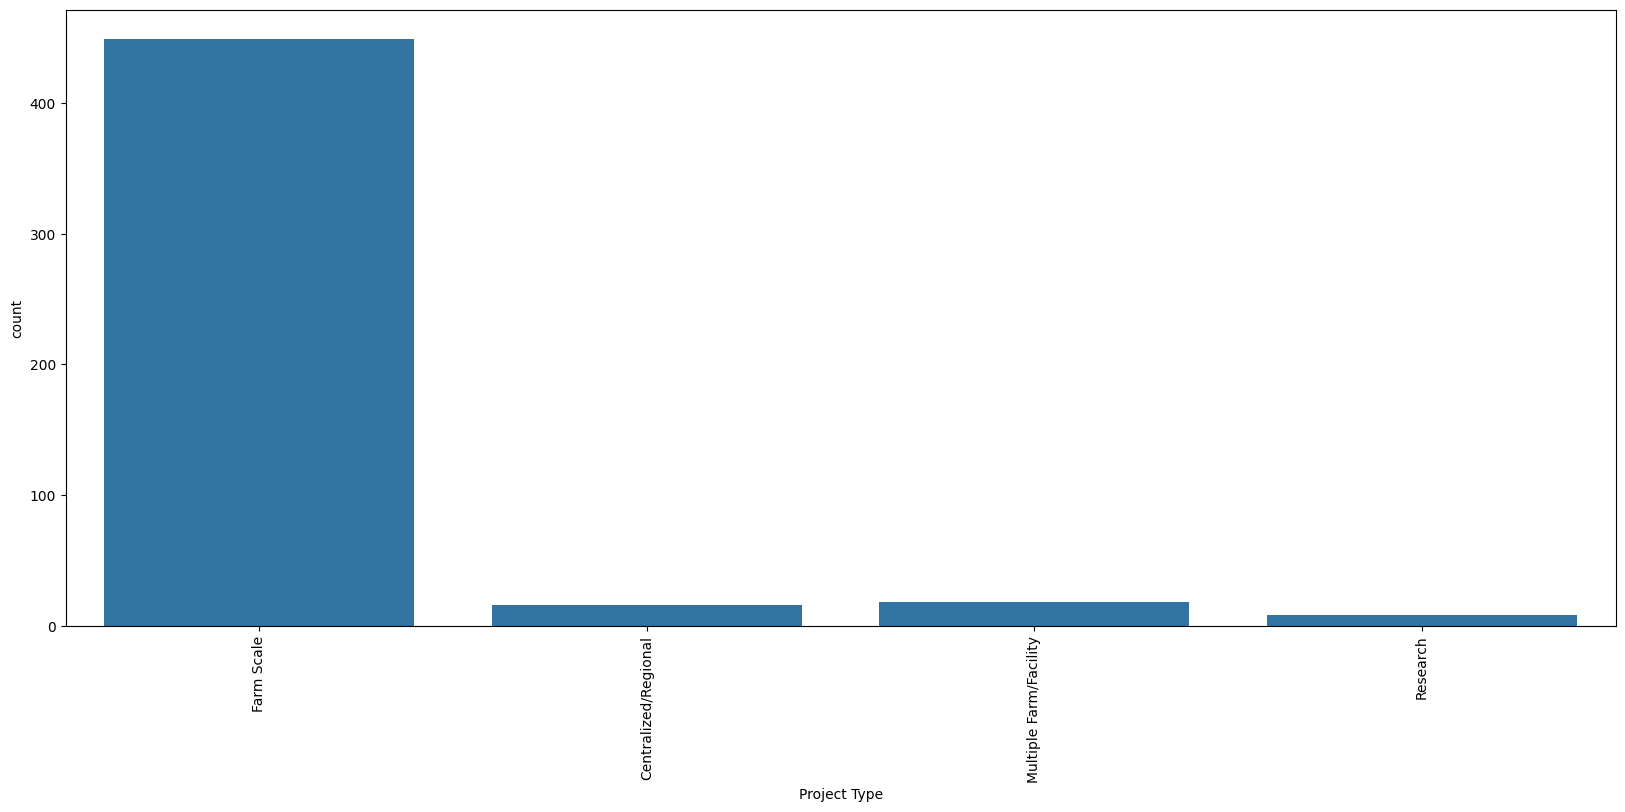

                                                    Digester Type  Ratio
Digester Type                                                           
Covered Lagoon                                                176 35.845
Complete Mix                                                  127 25.866
Mixed Plug Flow                                               115 23.422
Horizontal Plug Flow                                           34  6.925
Unknown or Unspecified                                         10  2.037
Fixed Film/Attached Media                                       7  1.426
Induced Blanket Reactor                                         7  1.426
Plug Flow - Unspecified                                         4  0.815
Anaerobic Sequencing Batch Reactor                              3  0.611
Vertical Plug Flow                                              3  0.611
Modular Plug Flow                                               2  0.407
No-Info                                            

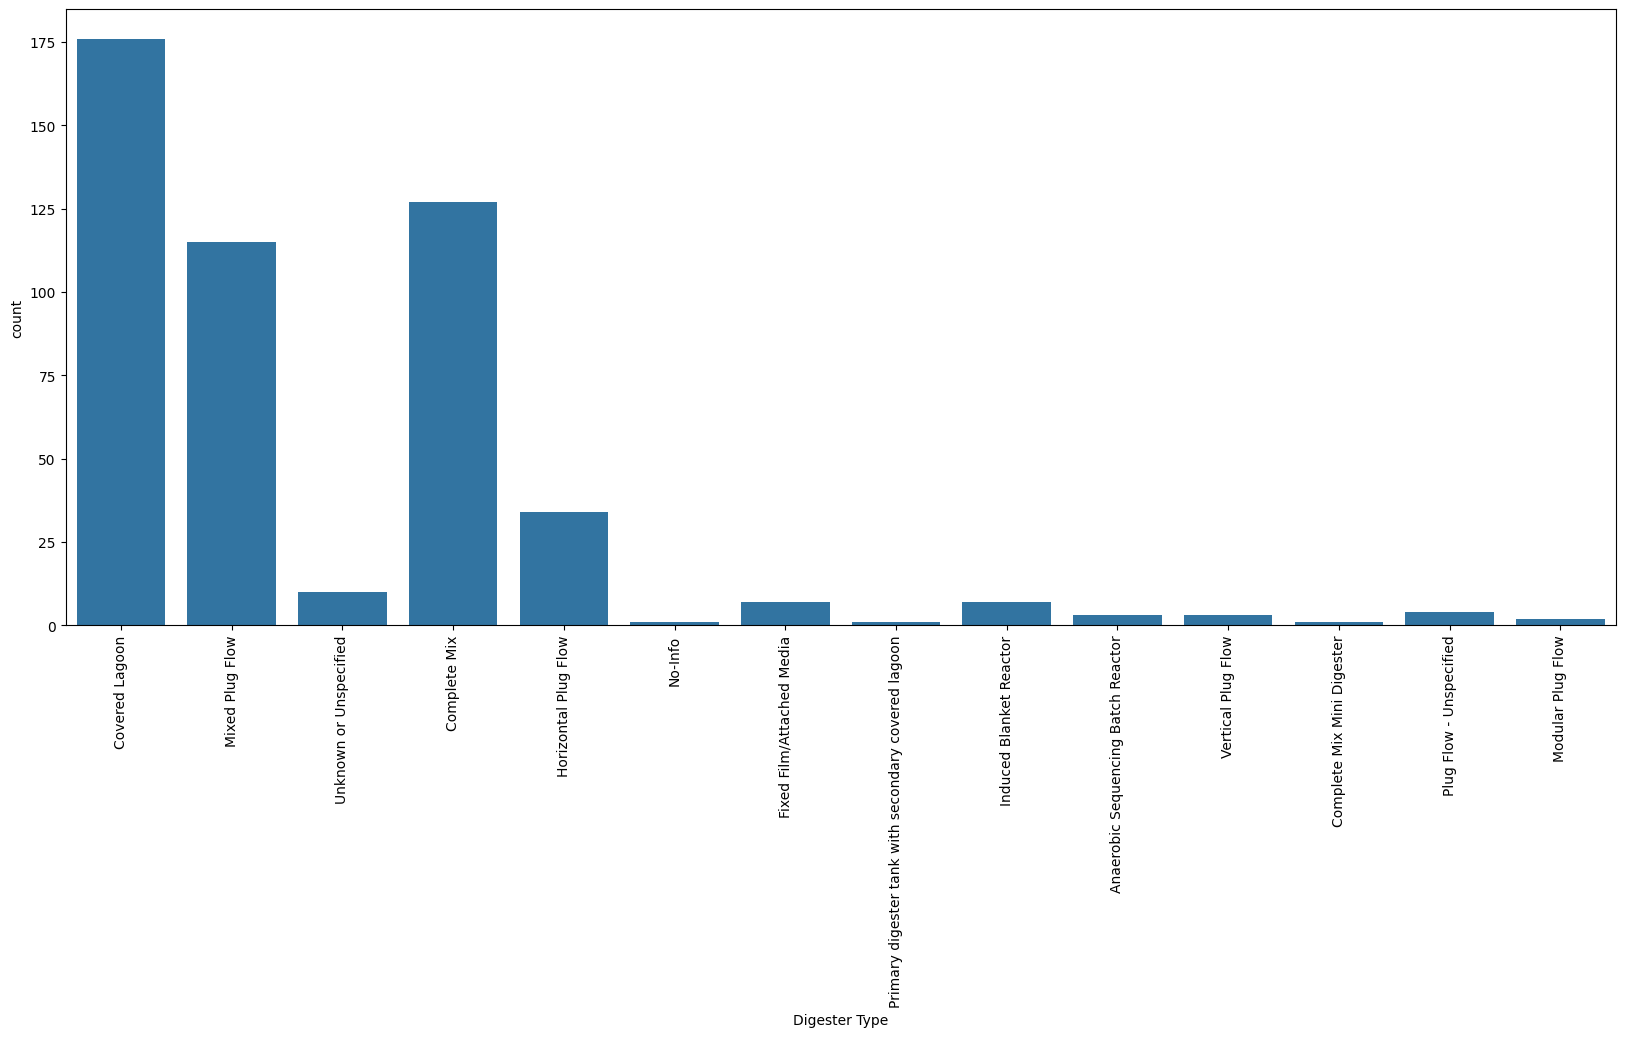

              Status  Ratio
Status                     
Operational      327 66.599
Shut down         86 17.515
Construction      78 15.886
##########################################


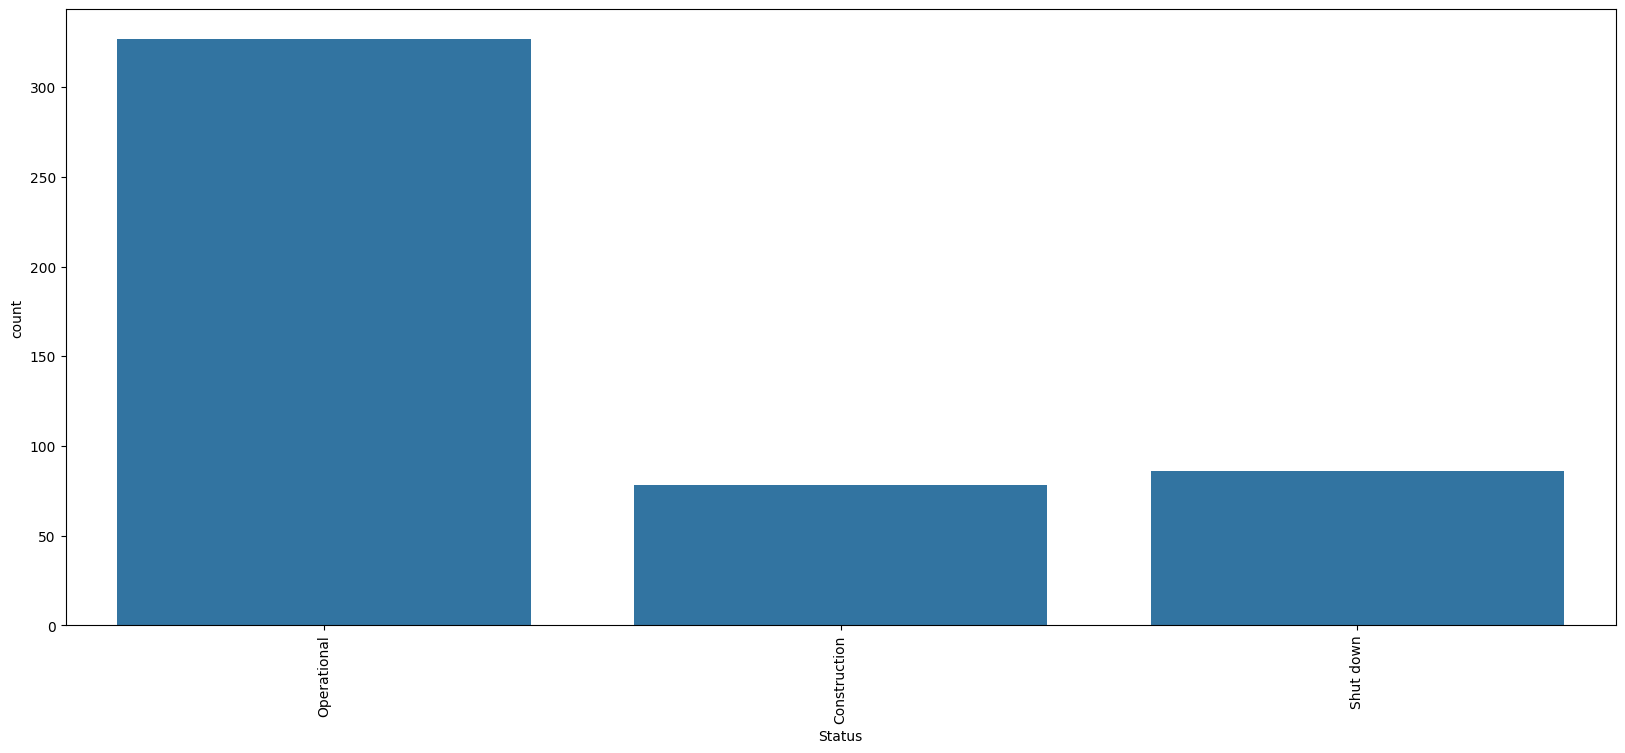

                       Animal/Farm Type(s)  Ratio
Animal/Farm Type(s)                              
Dairy                                  414 84.318
Swine                                   50 10.183
Poultry                                 11  2.240
Cattle                                   5  1.018
Cattle; Swine                            4  0.815
Dairy; Swine                             3  0.611
Cattle; Dairy                            2  0.407
Dairy; Poultry; Swine                    1  0.204
Cattle; Poultry                          1  0.204
##########################################


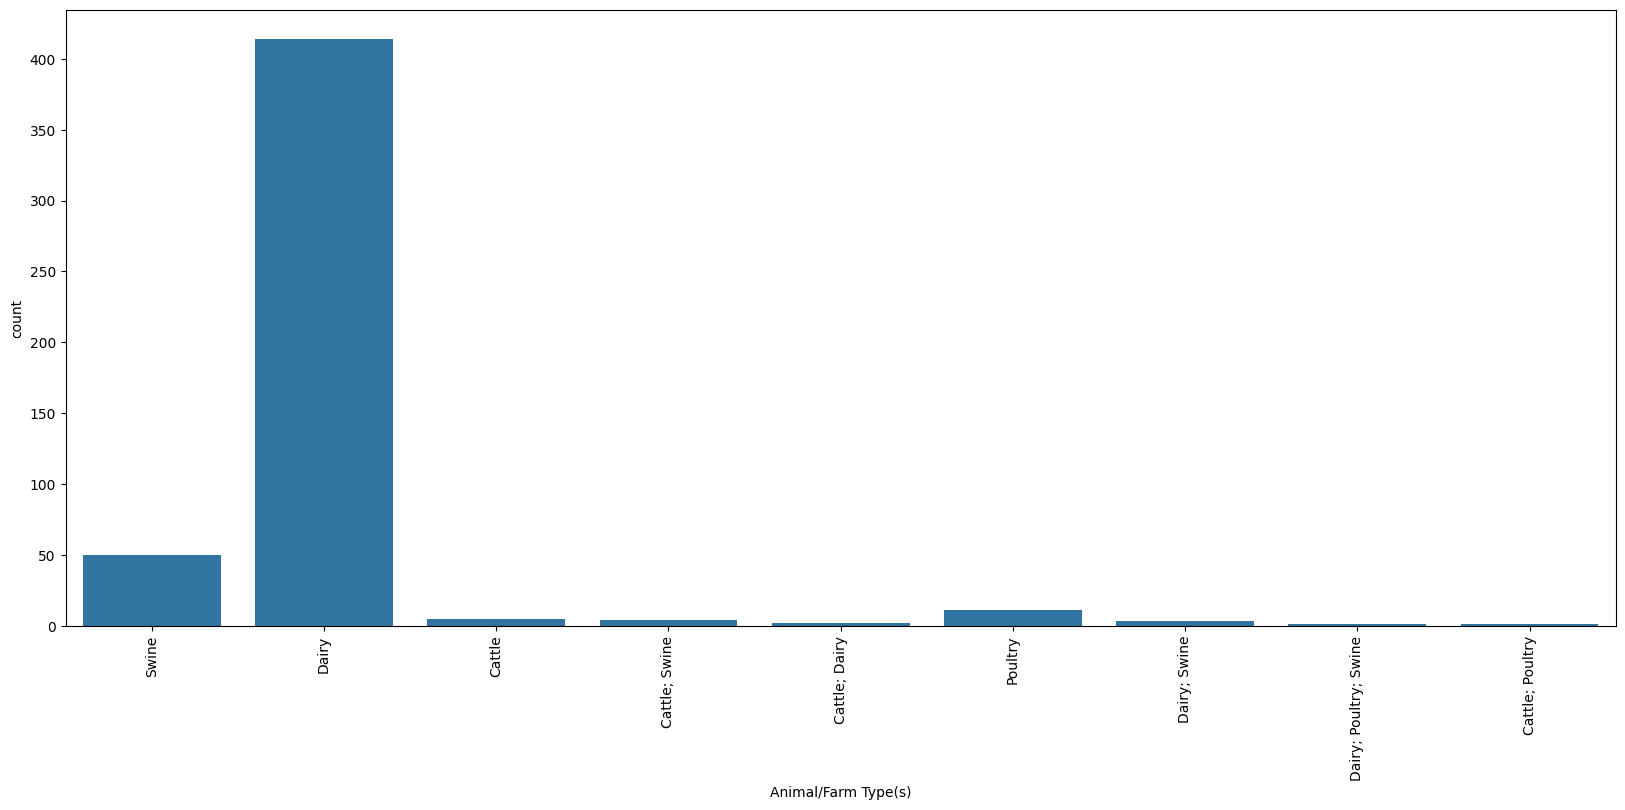

              Co-Digestion  Ratio
Co-Digestion                     
No-Info                365 74.338
Yes                    126 25.662
##########################################


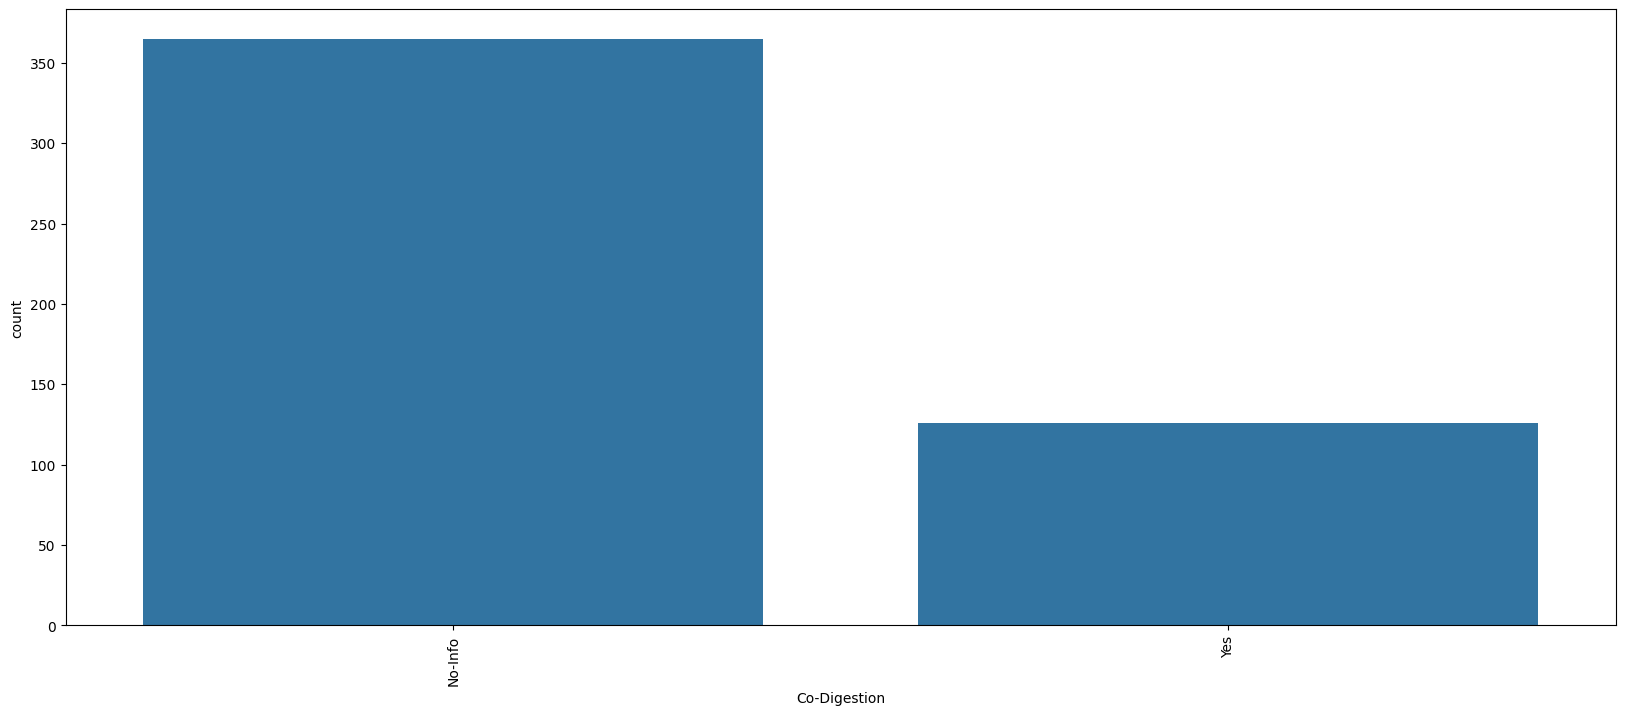

                                                Biogas End Use(s)  Ratio
Biogas End Use(s)                                                       
Cogeneration                                                  116 23.625
CNG                                                           114 23.218
Electricity                                                   109 22.200
Pipeline Gas                                                   67 13.646
Boiler/Furnace fuel                                            18  3.666
Flared Full-time                                               16  3.259
Electricity; Cogeneration                                       9  1.833
Electricity; Boiler/Furnace fuel                                8  1.629
Cogeneration; Boiler/Furnace fuel                               7  1.426
No-Info                                                         6  1.222
Electricity; CNG                                                4  0.815
Cogeneration; CNG                                  

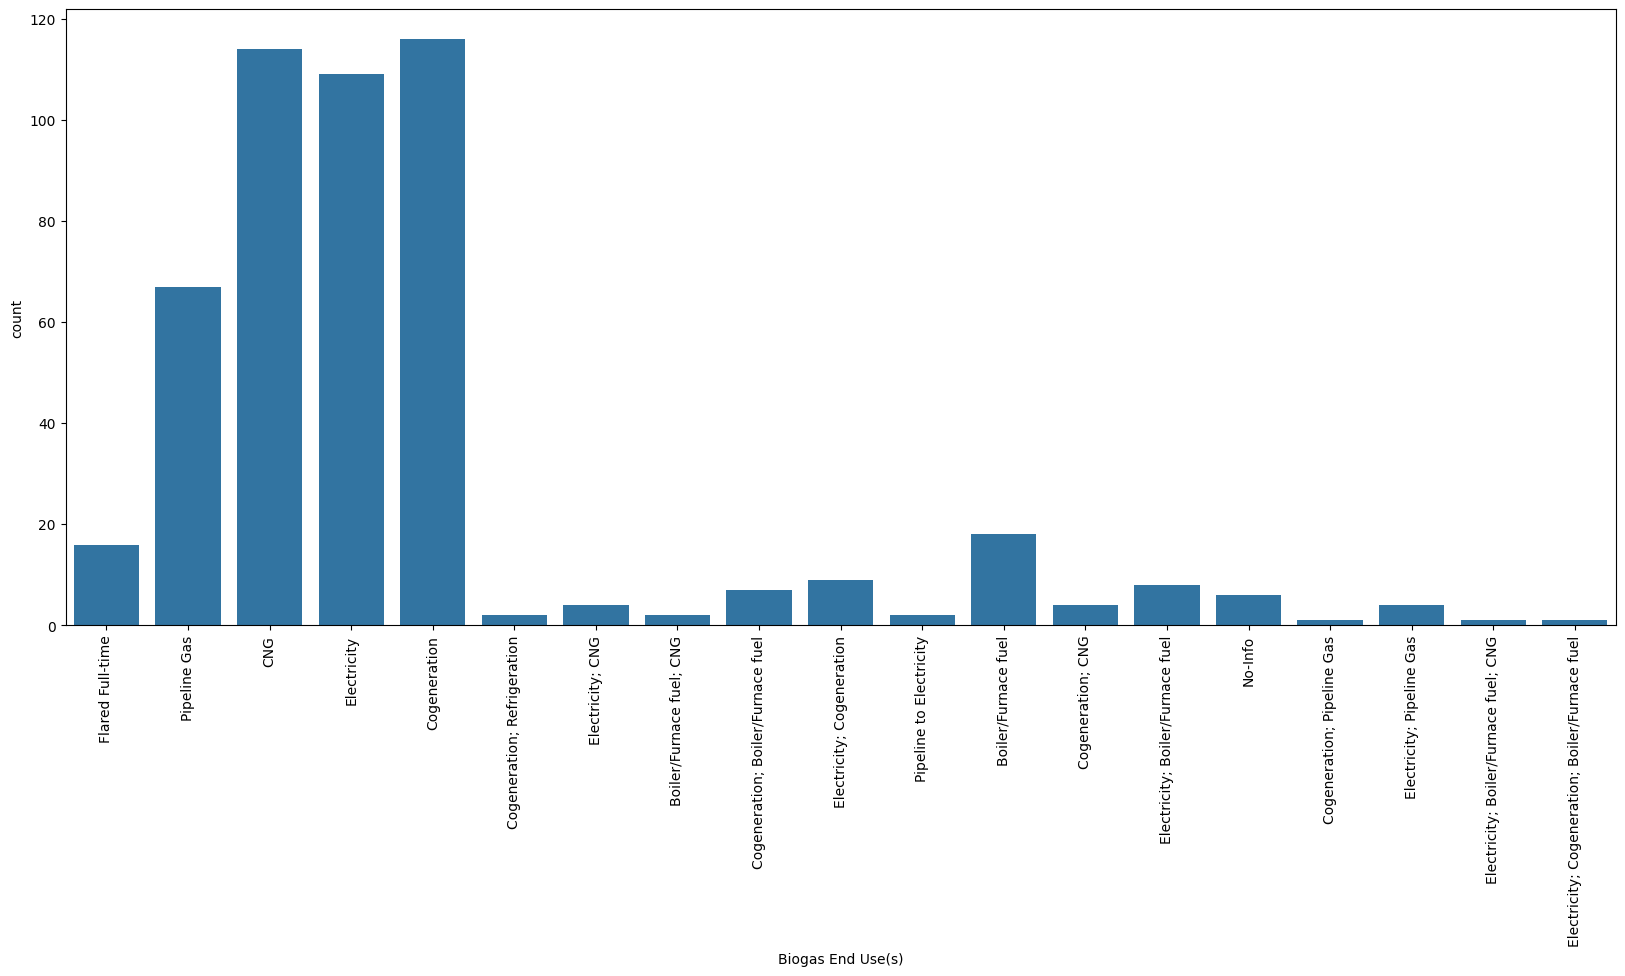

               LCFS Pathway?  Ratio
LCFS Pathway?                      
No-Info                  405 82.485
Yes                       86 17.515
##########################################


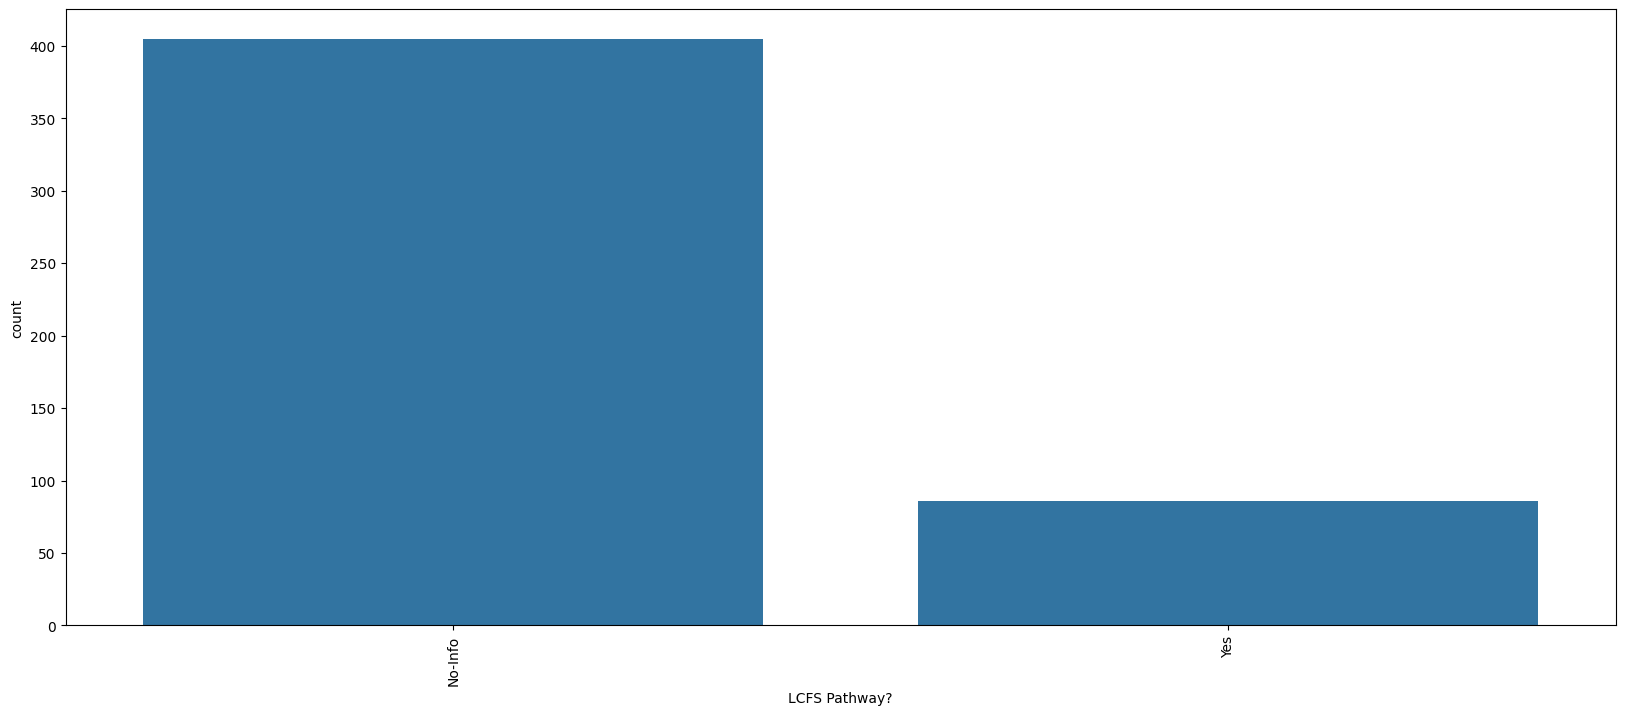

                   Receiving Utility  Ratio
Receiving Utility                          
No-Info                          255 51.935
Yes                              236 48.065
##########################################


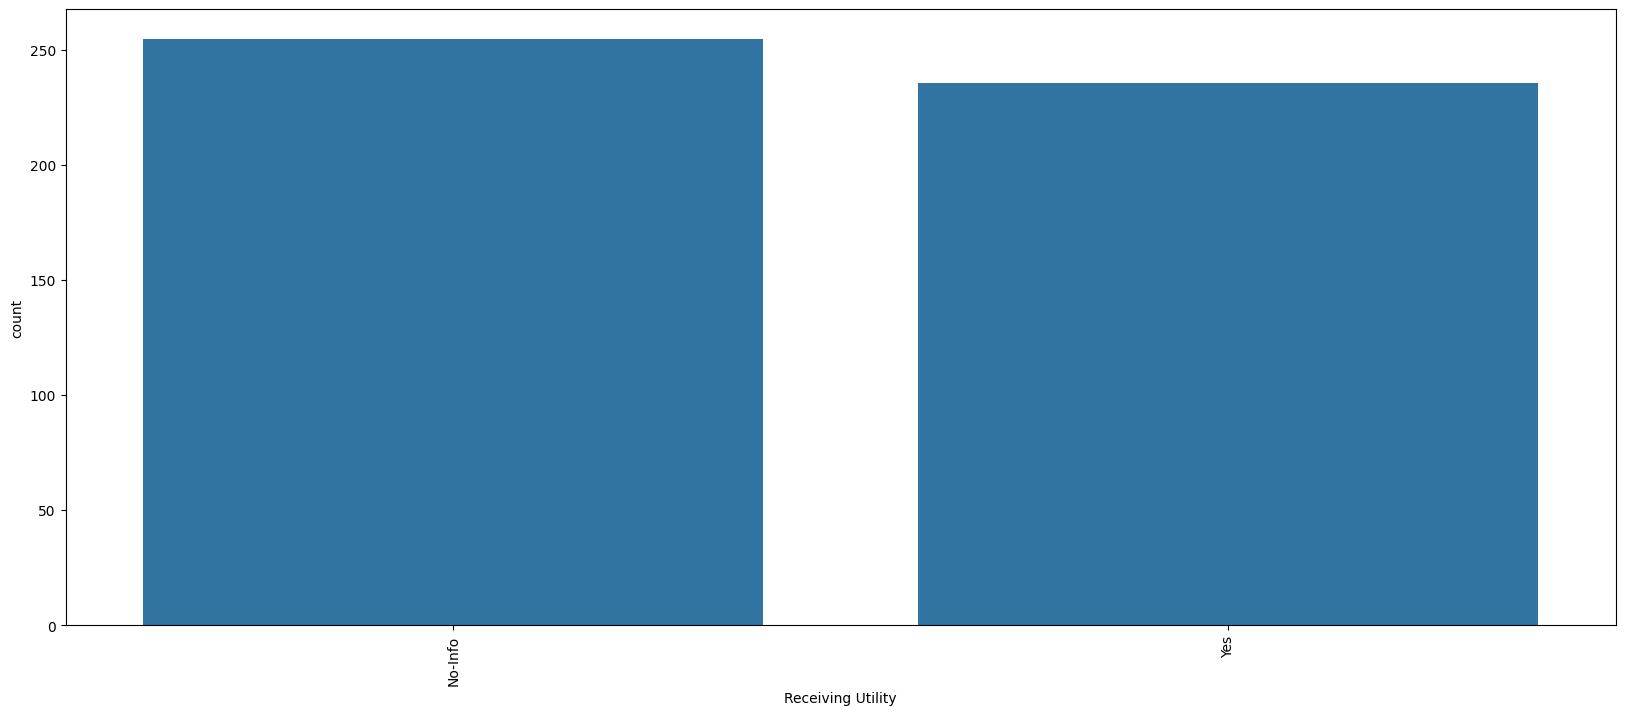

                       Awarded USDA Funding?  Ratio
Awarded USDA Funding?                              
No-Info                                  365 74.338
Yes                                      126 25.662
##########################################


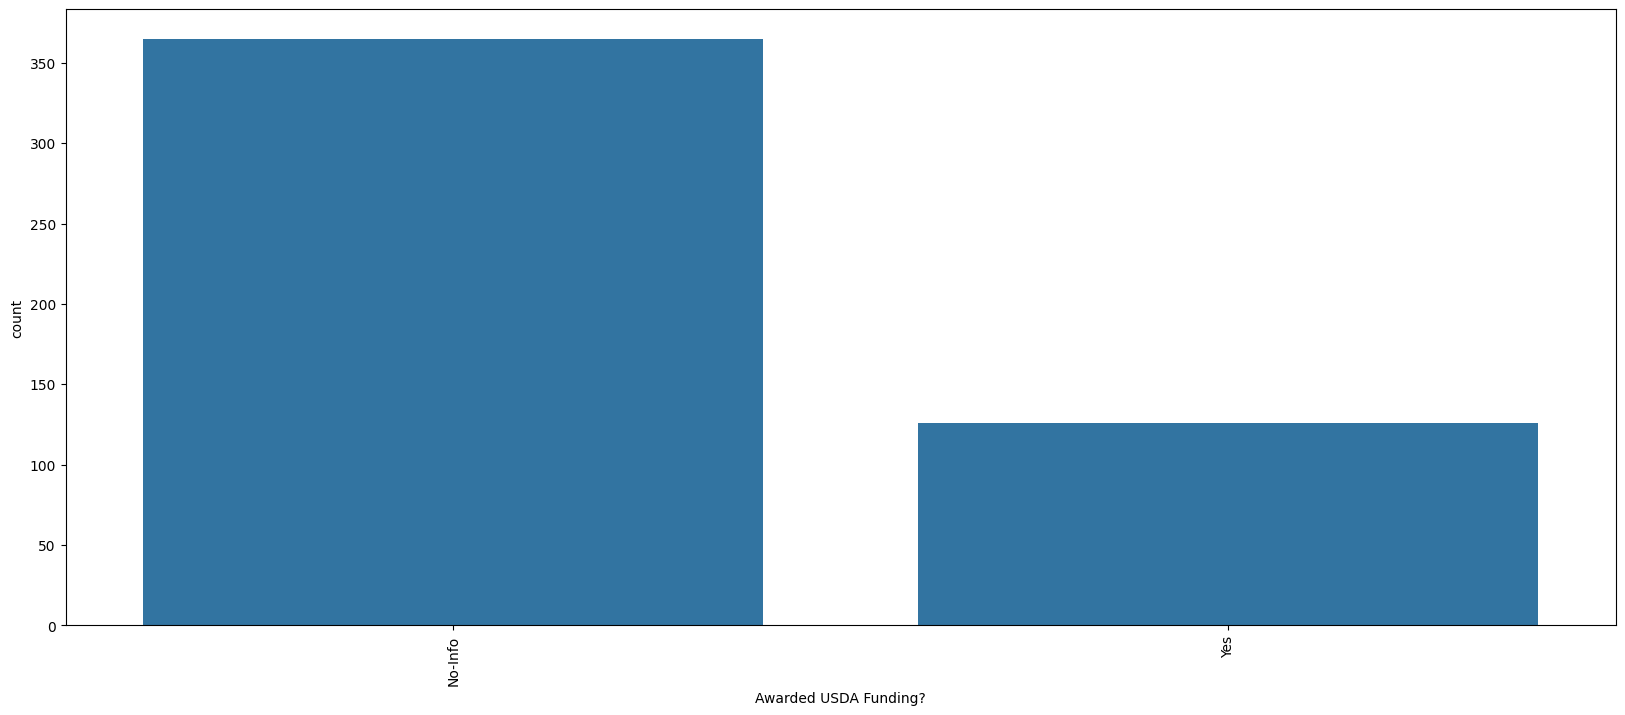

In [19]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

In [20]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)

        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

count    491.000
mean    2012.572
std        8.772
min     1972.000
5%      1998.000
10%     2003.000
20%     2006.000
30%     2008.000
40%     2010.000
50%     2012.000
60%     2015.000
70%     2020.000
80%     2021.000
90%     2022.000
95%     2023.000
99%     2025.000
max     2025.000
Name: Year Operational, dtype: float64


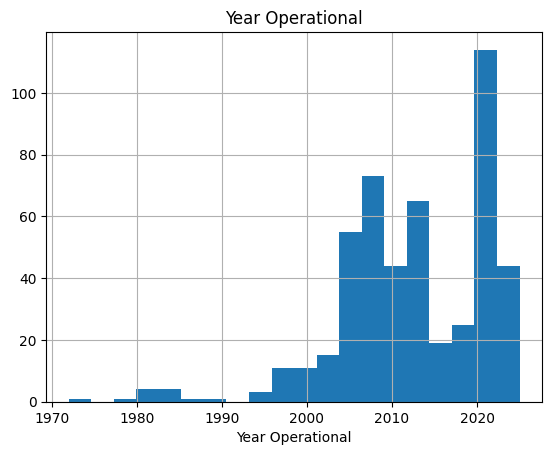

count     491.000
mean      183.523
std      2237.160
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%      2700.000
max     40000.000
Name: Cattle, dtype: float64


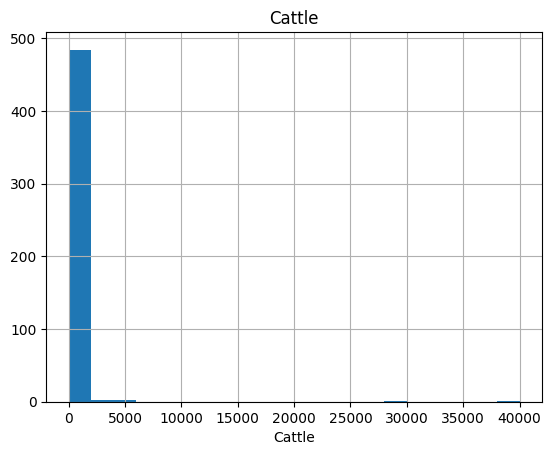

count     491.000
mean     3543.305
std      4984.927
min         0.000
5%          0.000
10%         0.000
20%       380.000
30%       800.000
40%      1200.000
50%      2000.000
60%      2700.000
70%      4000.000
80%      6244.000
90%      8100.000
95%     10375.000
99%     30250.000
max     39000.000
Name: Dairy, dtype: float64


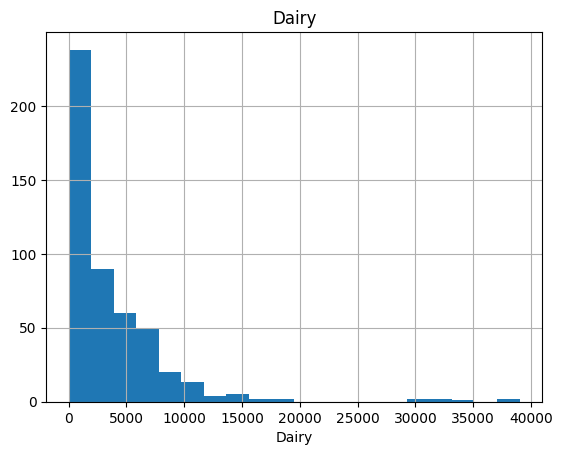

count       491.000
mean       6087.576
std       61662.896
min           0.000
5%            0.000
10%           0.000
20%           0.000
30%           0.000
40%           0.000
50%           0.000
60%           0.000
70%           0.000
80%           0.000
90%           0.000
95%           0.000
99%      132000.000
max     1200000.000
Name: Poultry, dtype: float64


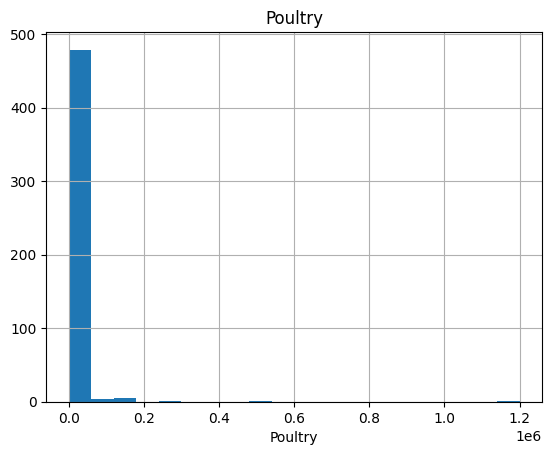

count      491.000
mean      2969.495
std      17713.659
min          0.000
5%           0.000
10%          0.000
20%          0.000
30%          0.000
40%          0.000
50%          0.000
60%          0.000
70%          0.000
80%          0.000
90%       2000.000
95%       9696.000
99%      80050.000
max     239200.000
Name: Swine, dtype: float64


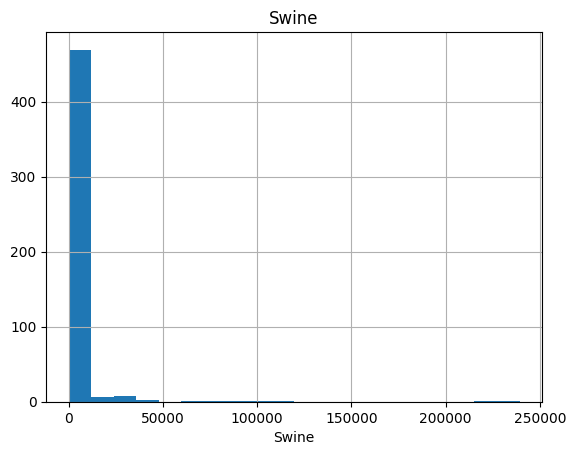

count       491.000
mean     443918.462
std      414336.111
min        5000.000
5%        33692.500
10%       53000.000
20%       90000.000
30%      116328.000
40%      242000.000
50%      344690.000
60%      459250.000
70%      636885.200
80%      710085.200
90%      908085.200
95%     1017422.600
99%     1817830.000
max     3454500.000
Name: Biogas Generation Estimate (cu-ft/day), dtype: float64


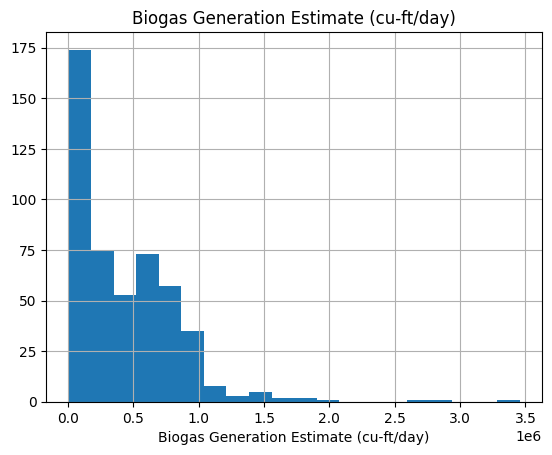

count        491.000
mean     2218724.163
std      4487113.724
min            0.000
5%             0.000
10%            0.000
20%            0.000
30%            0.000
40%       420480.000
50%       756437.800
60%      1226400.000
70%      2097496.000
80%      3682003.200
90%      6175800.000
95%      8216981.400
99%     16276400.000
max     70364700.000
Name: Electricity Generated (kWh/yr), dtype: float64


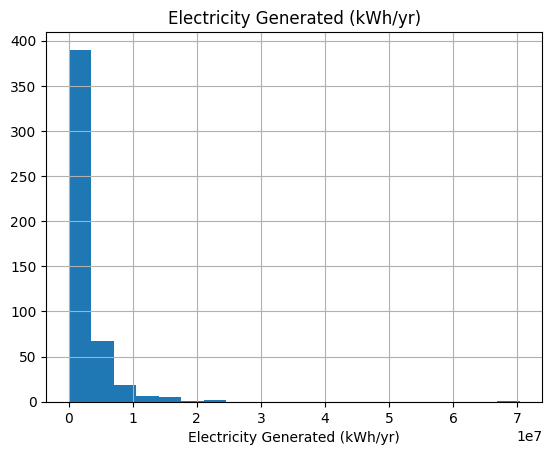

count      491.000
mean     38377.984
std      45532.724
min          4.220
5%        2018.512
10%       3258.126
20%       6321.348
30%      10884.821
40%      17882.766
50%      24094.429
60%      35566.164
70%      46826.723
80%      58590.365
90%      87163.215
95%     103921.221
99%     255068.927
max     390000.011
Name: Total Emission Reductions (MTCO2e/yr), dtype: float64


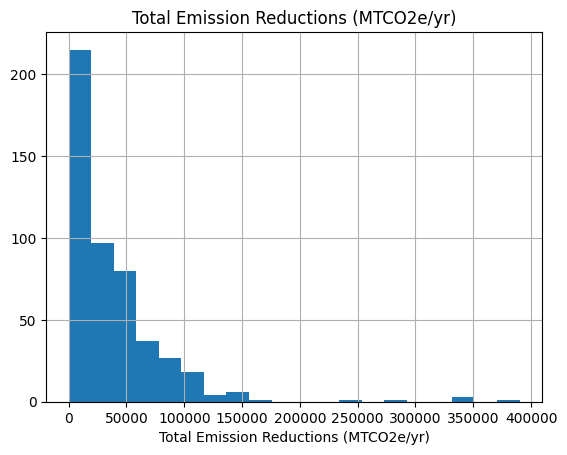

count   491.000
mean     10.489
std       8.692
min       0.000
5%        0.000
10%       1.000
20%       2.000
30%       3.000
40%       8.000
50%      11.000
60%      13.000
70%      15.000
80%      17.000
90%      20.000
95%      25.000
99%      41.000
max      51.000
Name: Operational Years, dtype: float64


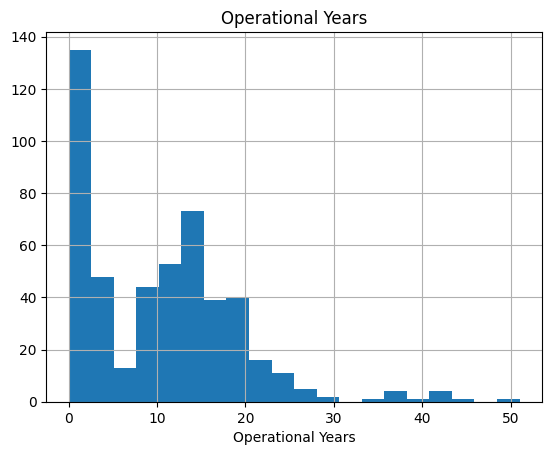

count       491.000
mean      12783.900
std       63625.761
min          10.000
5%          350.000
10%         520.000
20%         915.000
30%        1500.000
40%        2100.000
50%        3157.000
60%        4500.000
70%        6300.000
80%        7890.000
90%       14000.000
95%       34000.000
99%      166000.000
max     1200000.000
Name: Total_Animals, dtype: float64


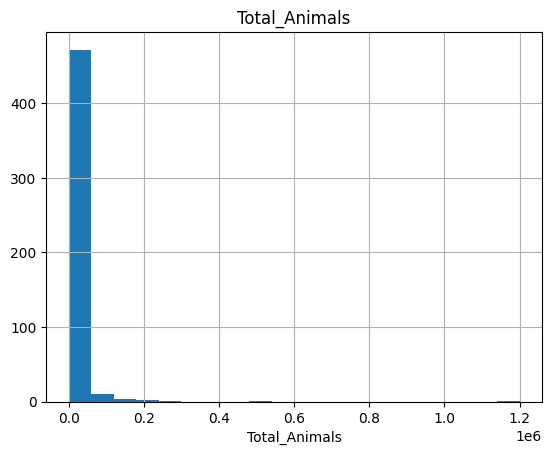

count     491.000
mean      527.755
std      4241.481
min         0.389
5%          4.050
10%        13.855
20%        35.579
30%        50.000
40%        50.000
50%        75.625
60%       105.000
70%       140.240
80%       310.866
90%       695.685
95%      1445.031
99%      5324.617
max     90654.520
Name: Biogas_per_Animal (cu-ft/day), dtype: float64


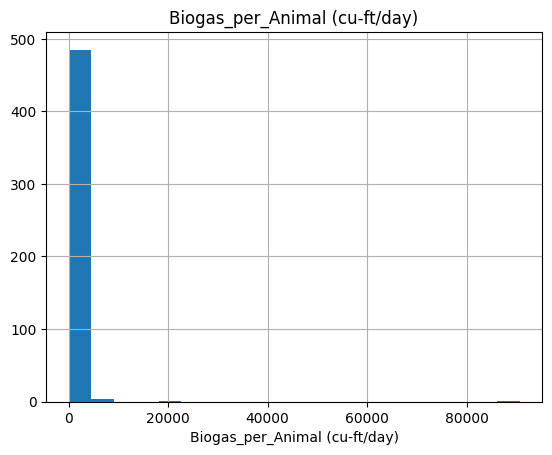

count      491.000
mean      9914.176
std      18366.545
min          0.000
5%           0.000
10%         20.495
20%        233.114
30%        556.326
40%        897.038
50%       1695.220
60%       3030.187
70%       5686.140
80%      14376.877
90%      34232.432
95%      57594.204
99%      84177.465
max     130000.004
Name: Emission_Reduction_per_Year, dtype: float64


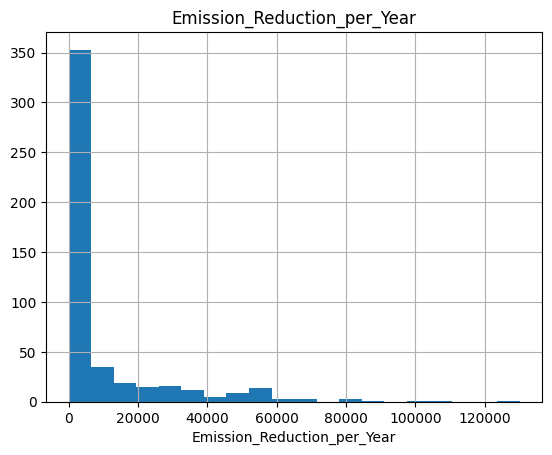

count   491.000
mean     10.061
std      19.005
min       0.000
5%        0.000
10%       0.000
20%       0.000
30%       0.000
40%       1.473
50%       3.996
60%       6.923
70%      10.062
80%      14.857
90%      22.827
95%      40.080
99%      97.790
max     174.270
Name: Electricity_to_Biogas_Ratio, dtype: float64


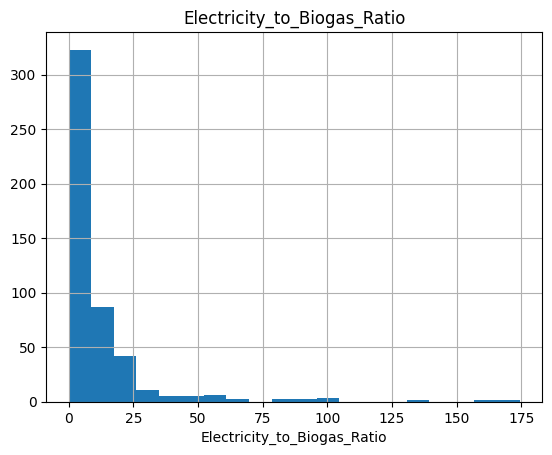

count       491.000
mean     139538.212
std      195557.633
min          50.000
5%         8500.000
10%       14450.000
20%       25500.000
30%       37500.000
40%       57800.000
50%       76500.000
60%      110500.000
70%      158975.000
80%      221000.000
90%      302600.000
95%      403920.000
99%     1106700.000
max     2126000.000
Name: Total_Waste_kg/day, dtype: float64


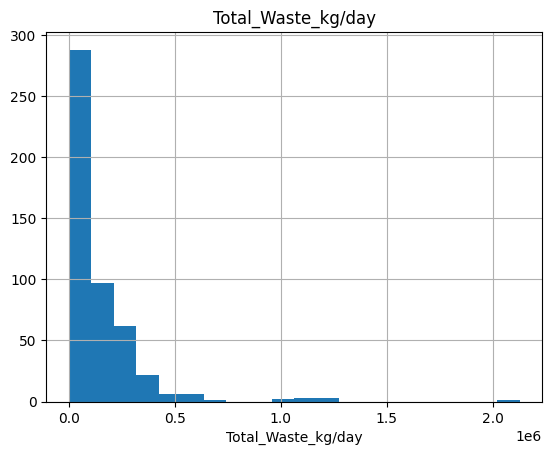

count     491.000
mean       51.685
std       819.431
min         0.043
5%          0.526
10%         0.809
20%         1.471
30%         1.471
40%         1.901
50%         2.689
60%         3.693
70%         6.868
80%        12.860
90%        25.494
95%        57.571
99%       199.093
max     18130.904
Name: Waste_Efficiency, dtype: float64


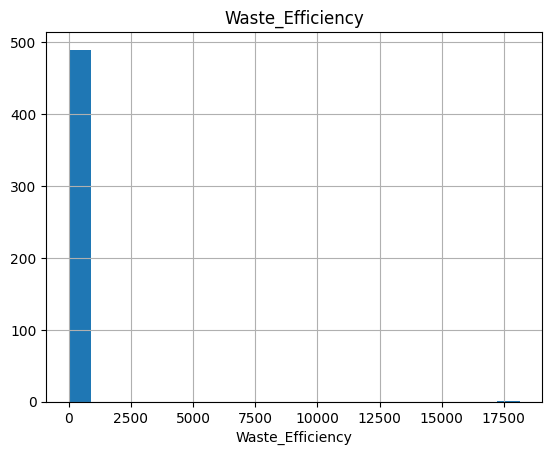

count    491.000
mean      40.765
std       93.331
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        7.087
50%       18.019
60%       25.748
70%       38.904
80%       52.560
90%       83.405
95%      141.574
99%      382.193
max     1150.824
Name: Electricity_Efficiency, dtype: float64


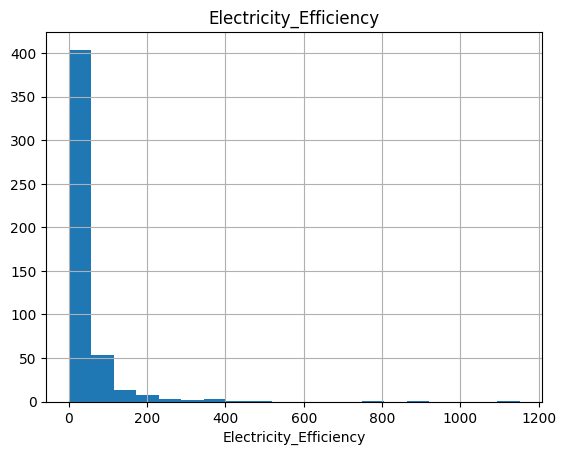

In [21]:
for col in num_cols:
    num_summary(df, col, plot=True)

In [22]:
def target_summary_with_cat(dataframe, target, categorical_col, plot=False):
    print(pd.DataFrame({'TARGET_MEAN': dataframe.groupby(categorical_col)[target].mean()}), end='\n\n\n')
    if plot:
        plt.figure(figsize=(20,8))
        sns.barplot(x=categorical_col, y=target, data=dataframe)
        plt.xticks(rotation=90)
        plt.show(block=True)

                        TARGET_MEAN
Project Type                       
Centralized/Regional     824127.762
Farm Scale               431612.794
Multiple Farm/Facility   502957.267
Research                 241318.150




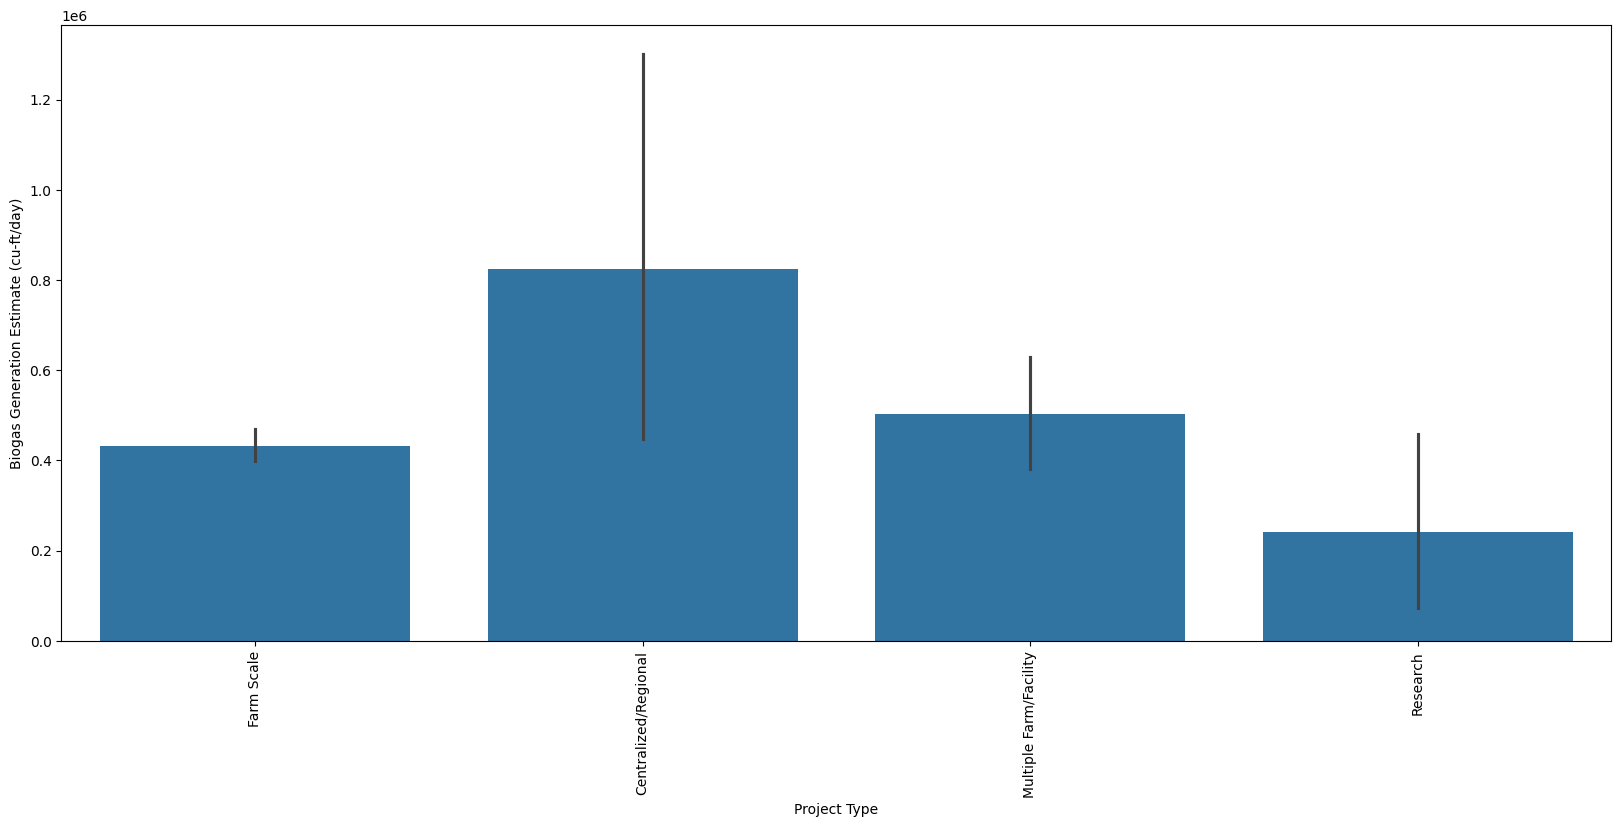

                                                    TARGET_MEAN
Digester Type                                                  
Anaerobic Sequencing Batch Reactor                   673445.200
Complete Mix                                         477362.301
Complete Mix Mini Digester                           635485.200
Covered Lagoon                                       419785.739
Fixed Film/Attached Media                            614621.486
Horizontal Plug Flow                                 258600.088
Induced Blanket Reactor                              451058.286
Mixed Plug Flow                                      503656.282
Modular Plug Flow                                      5000.000
No-Info                                              119215.400
Plug Flow - Unspecified                              214078.450
Primary digester tank with secondary covered la...   669885.200
Unknown or Unspecified                               339208.320
Vertical Plug Flow                      

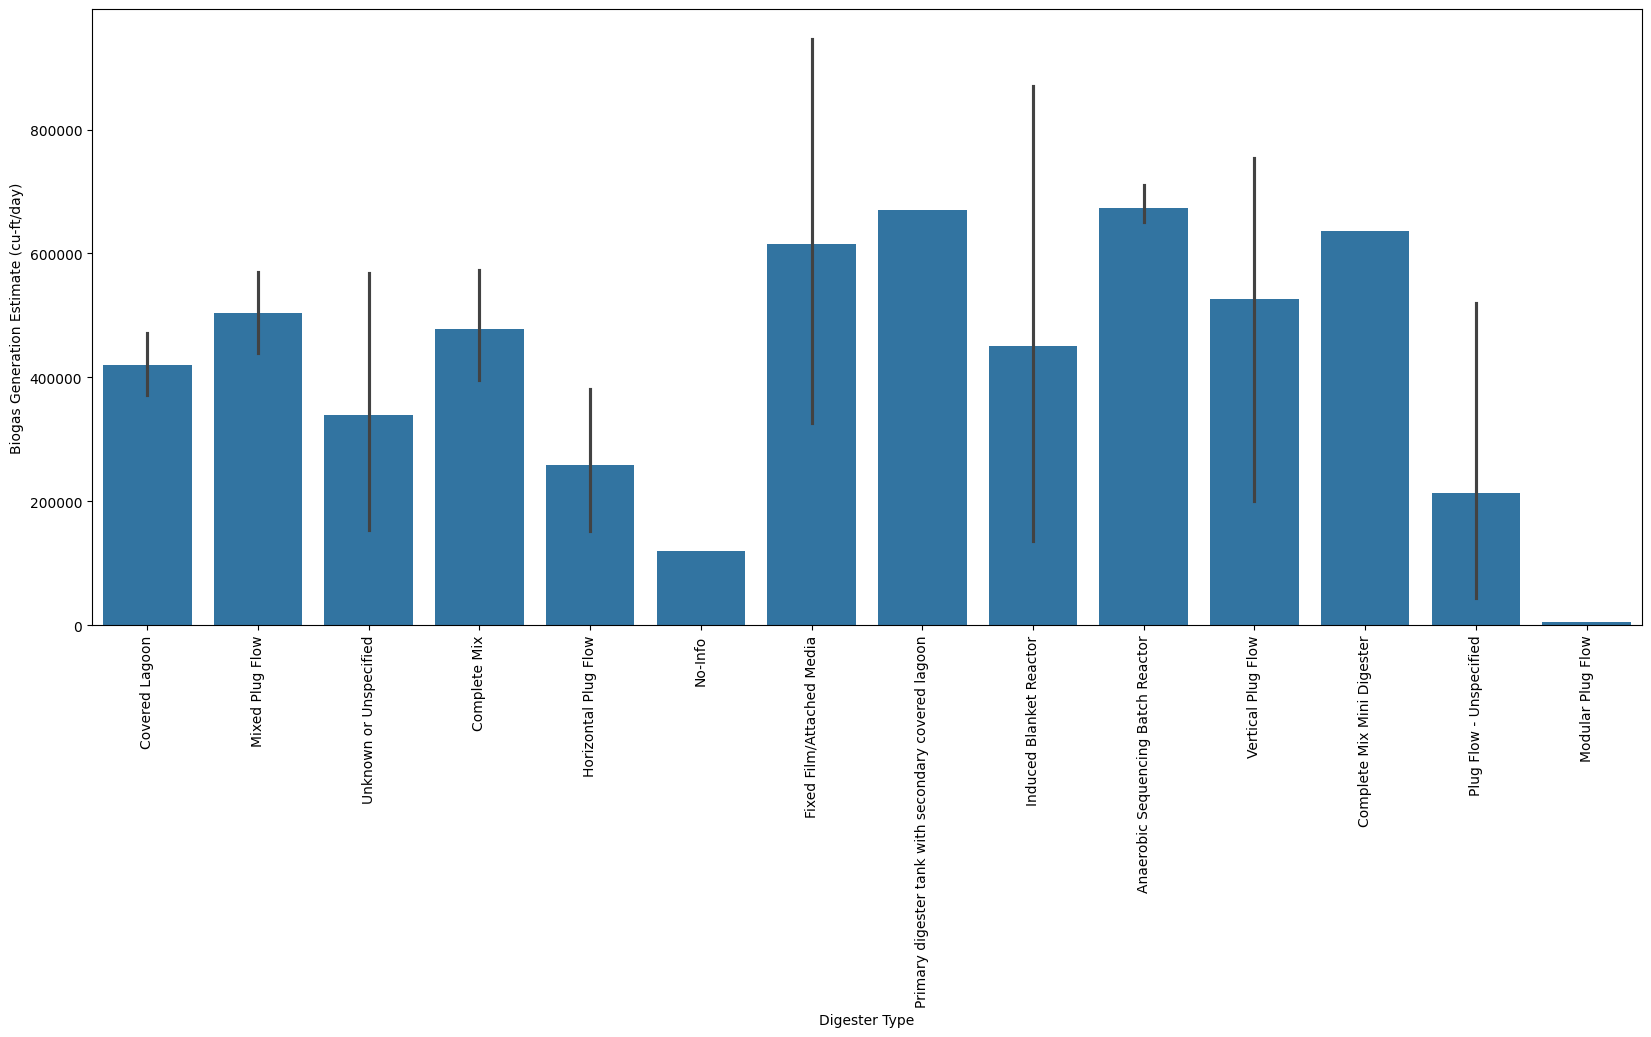

              TARGET_MEAN
Status                   
Construction   302770.649
Operational    469356.046
Shut down      475214.270




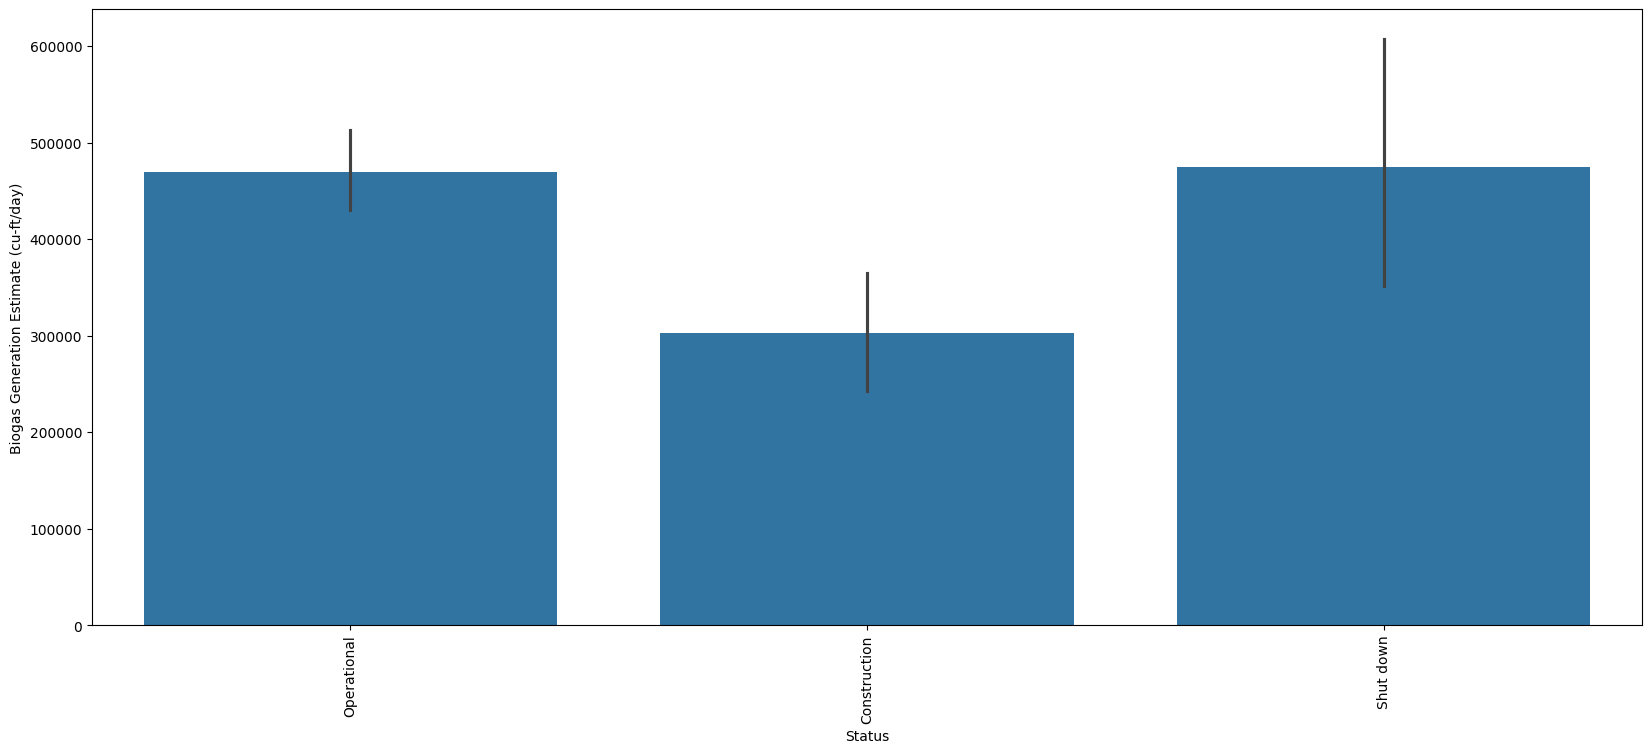

                       TARGET_MEAN
Animal/Farm Type(s)               
Cattle                  941794.080
Cattle; Dairy          1000242.600
Cattle; Poultry         445540.000
Cattle; Swine           824133.900
Dairy                   424527.933
Dairy; Poultry; Swine    49093.000
Dairy; Swine            558390.133
Poultry                 455966.545
Swine                   500359.476




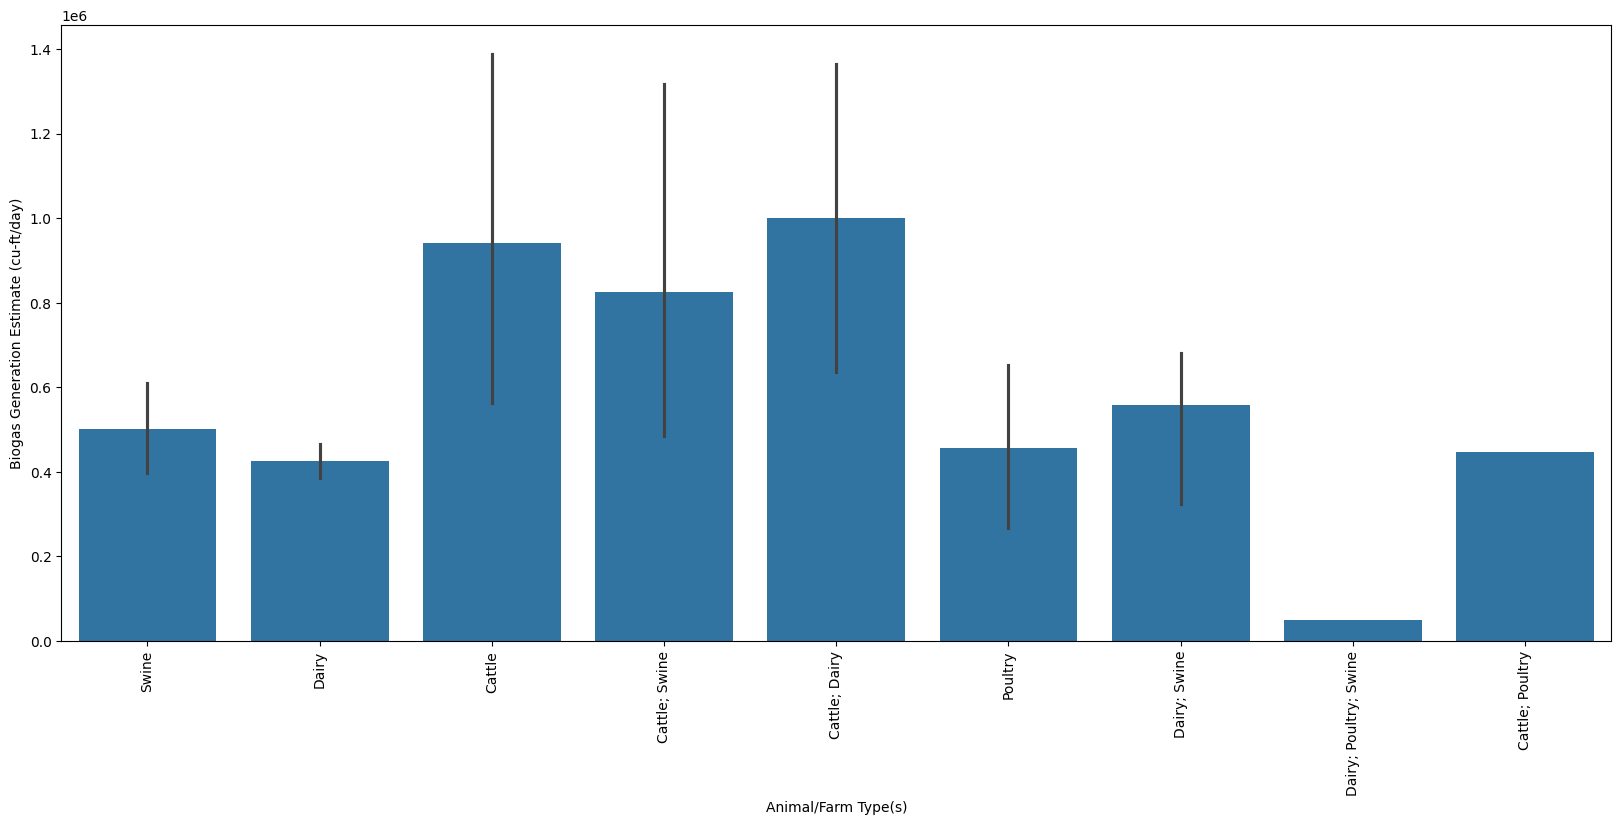

              TARGET_MEAN
Co-Digestion             
No-Info        431726.230
Yes            479237.229




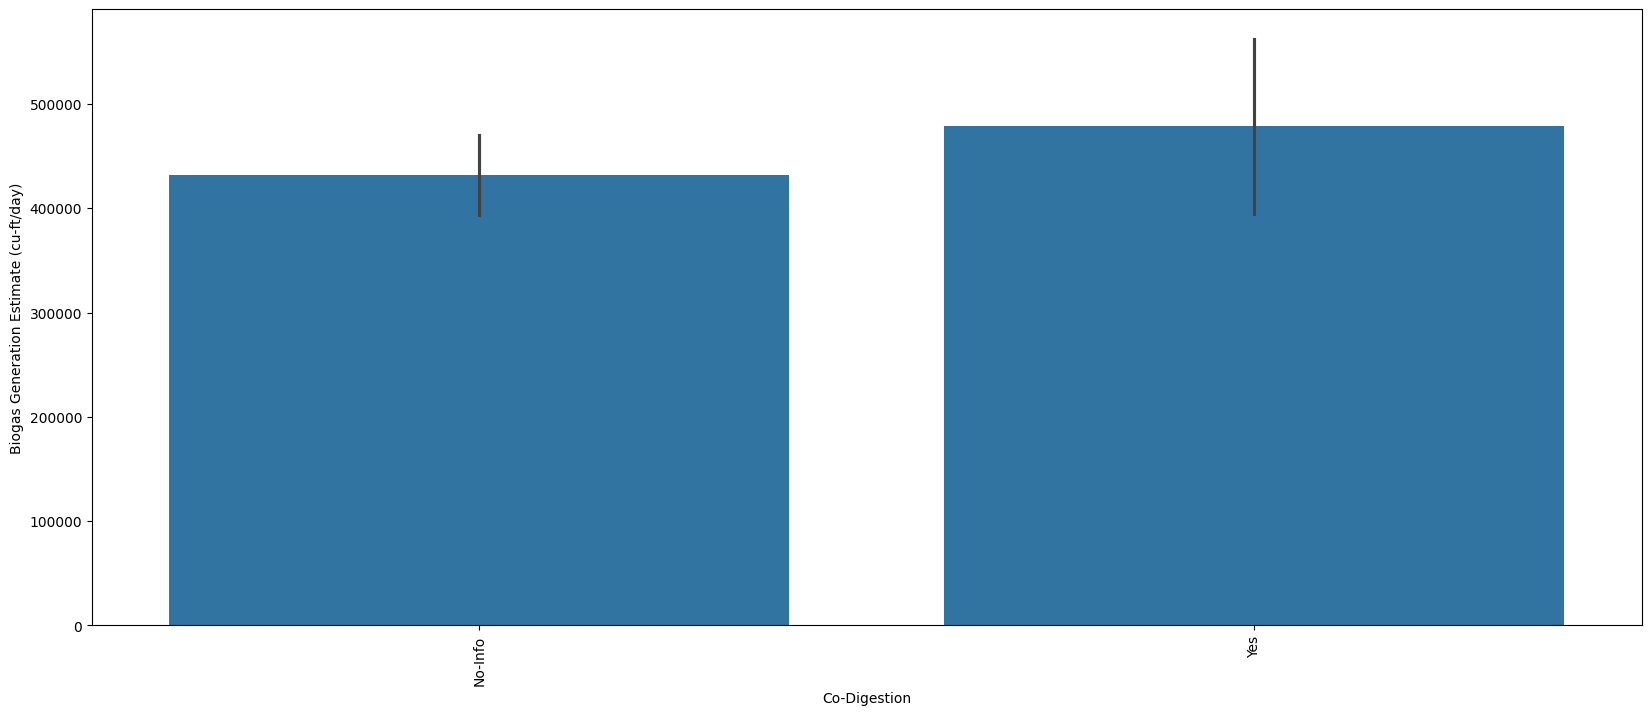

                                                TARGET_MEAN
Biogas End Use(s)                                          
Boiler/Furnace fuel                              527268.356
Boiler/Furnace fuel; CNG                         959245.200
CNG                                              441185.742
Cogeneration                                     440446.567
Cogeneration; Boiler/Furnace fuel                484933.057
Cogeneration; CNG                                408113.350
Cogeneration; Pipeline Gas                        55280.000
Cogeneration; Refrigeration                      141000.000
Electricity                                      479775.050
Electricity; Boiler/Furnace fuel                 327200.450
Electricity; Boiler/Furnace fuel; CNG            200919.000
Electricity; CNG                                 343047.650
Electricity; Cogeneration                        501430.178
Electricity; Cogeneration; Boiler/Furnace fuel   673685.200
Electricity; Pipeline Gas               

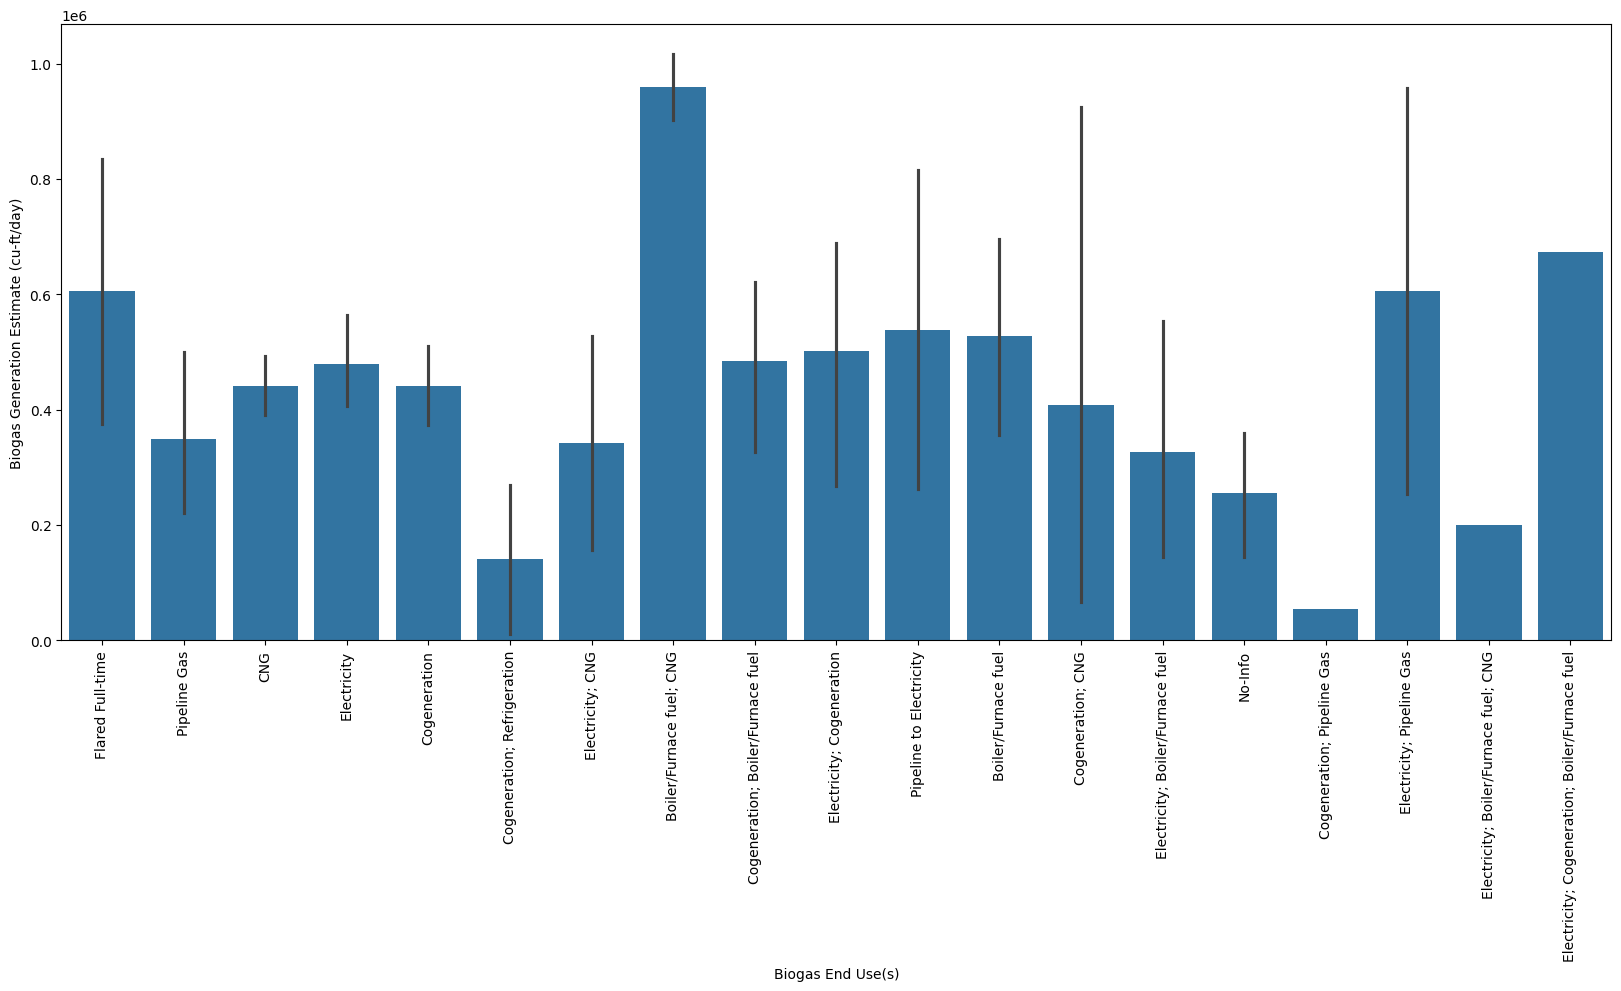

               TARGET_MEAN
LCFS Pathway?             
No-Info         435195.791
Yes             484996.156




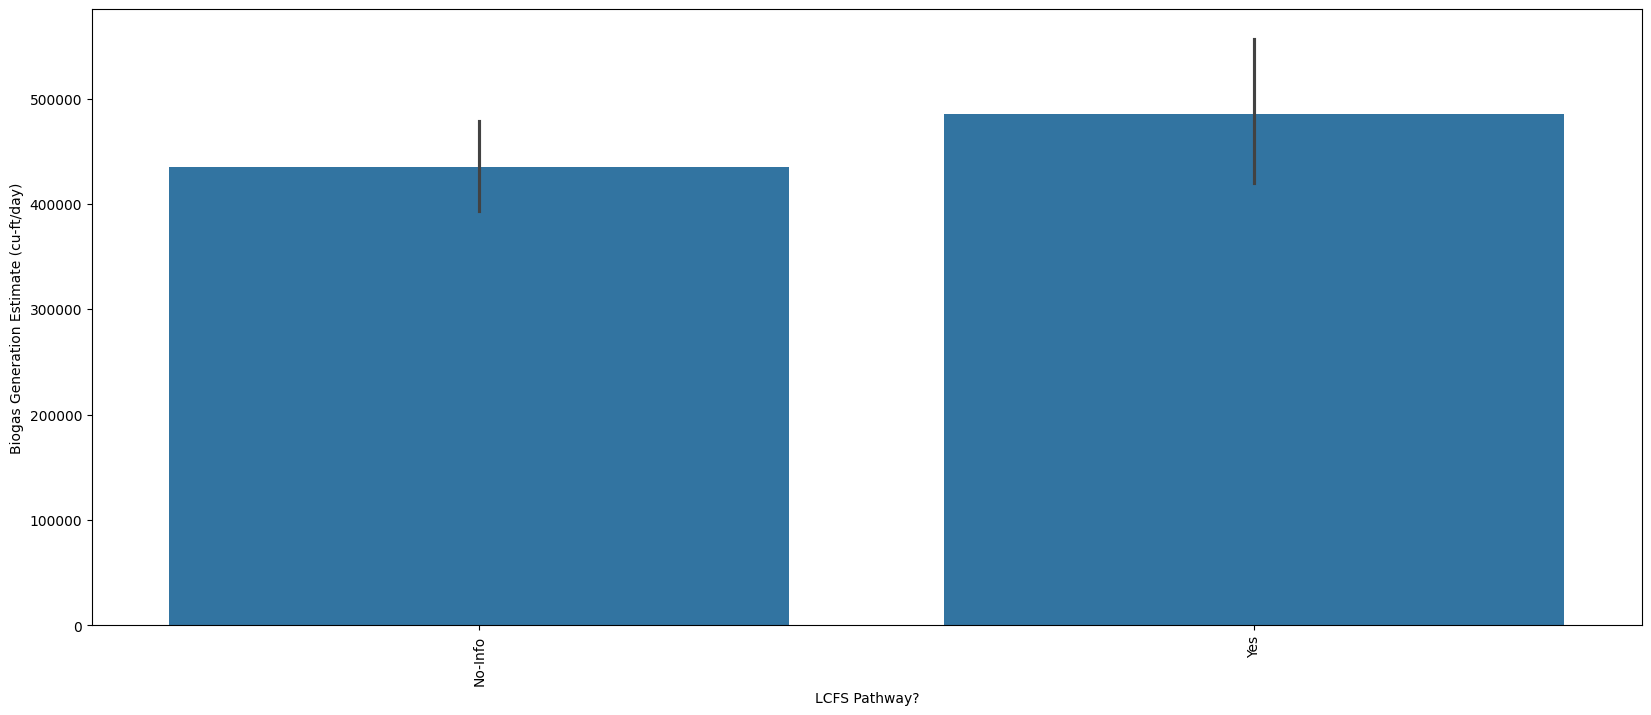

                   TARGET_MEAN
Receiving Utility             
No-Info             418653.311
Yes                 471217.671




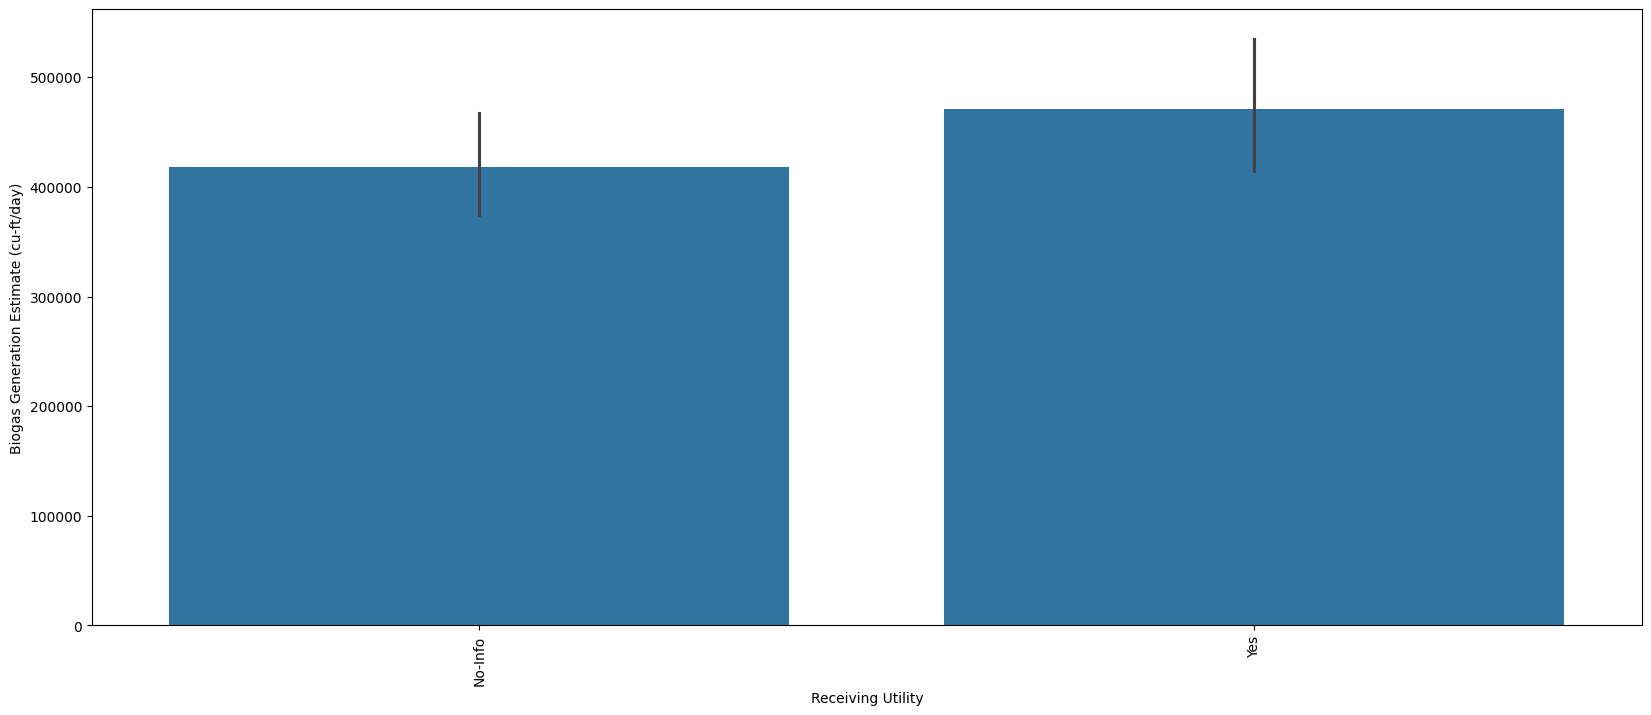

                       TARGET_MEAN
Awarded USDA Funding?             
No-Info                 440736.614
Yes                     453135.721




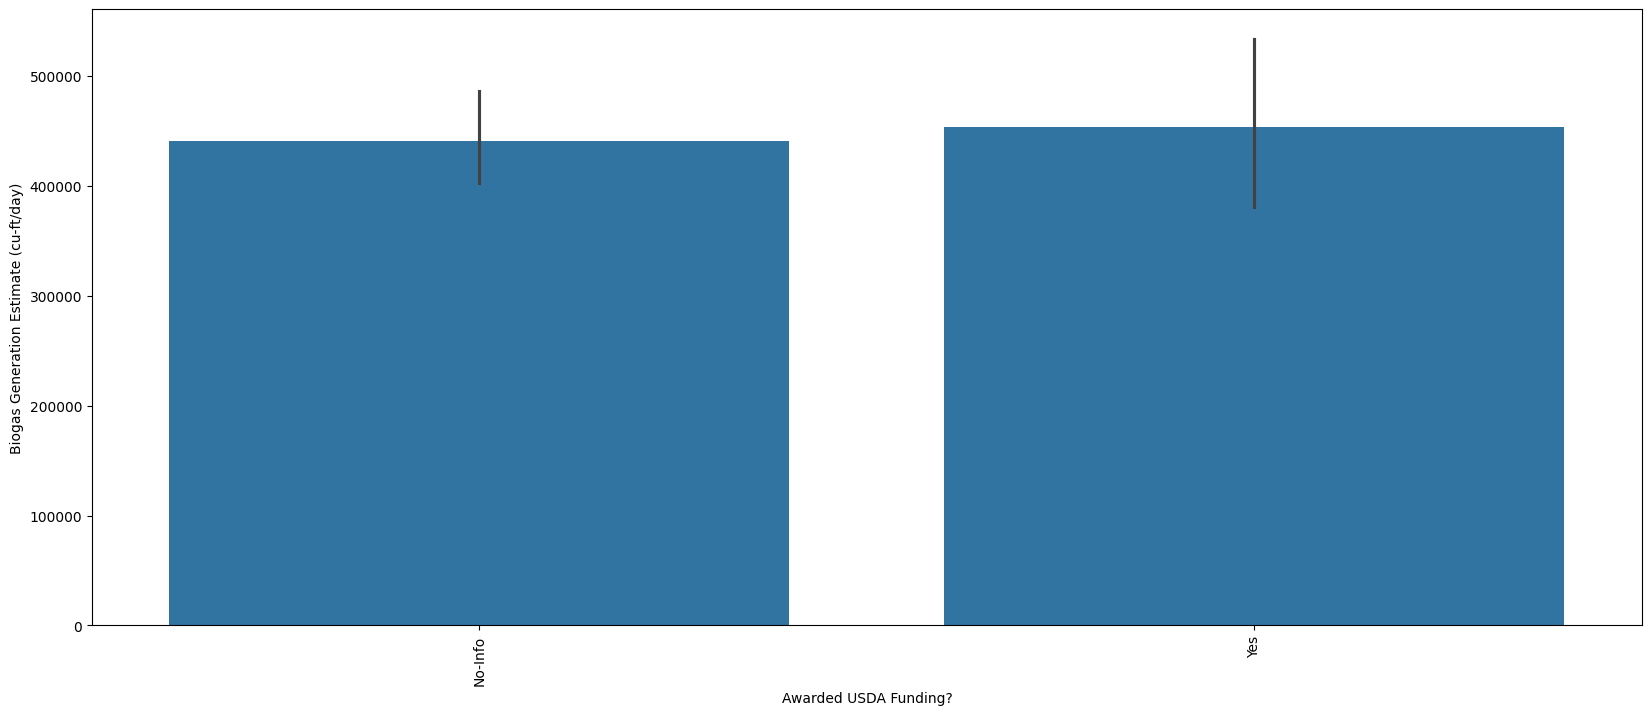

In [23]:
for col in cat_cols:
    target_summary_with_cat(df, 'Biogas Generation Estimate (cu-ft/day)', col, plot=True)

In [24]:
def target_summary_with_num(dataframe, target, numerical_col, plot=False):
    print(pd.DataFrame({numerical_col+'_mean': dataframe.groupby(target)[numerical_col].mean()}), end='\n\n\n')
    if plot:
        sns.barplot(x=target, y=numerical_col, data=dataframe)
        plt.show(block=True)

In [25]:
for col in num_cols:
    target_summary_with_num(df, 'Biogas Generation Estimate (cu-ft/day)', col, plot=False)

                                        Year Operational_mean
Biogas Generation Estimate (cu-ft/day)                       
5000.000                                             2008.000
11200.000                                            2004.000
12000.000                                            2000.500
13000.000                                            1994.000
14000.000                                            1997.500
...                                                       ...
1848700.000                                          2008.000
2000000.000                                          2019.000
2739726.000                                          2008.000
2908000.000                                          2006.000
3454500.000                                          2018.000

[310 rows x 1 columns]


                                        Cattle_mean
Biogas Generation Estimate (cu-ft/day)             
5000.000                                      0.000
11200.000   

In [26]:
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    corr = dataframe.corr(numeric_only=True)
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))  # np.bool changed to bool
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (16, 14)})
        sns.heatmap(corr, cmap="RdBu", annot=True, fmt=".2f")
        plt.show()
    return drop_list

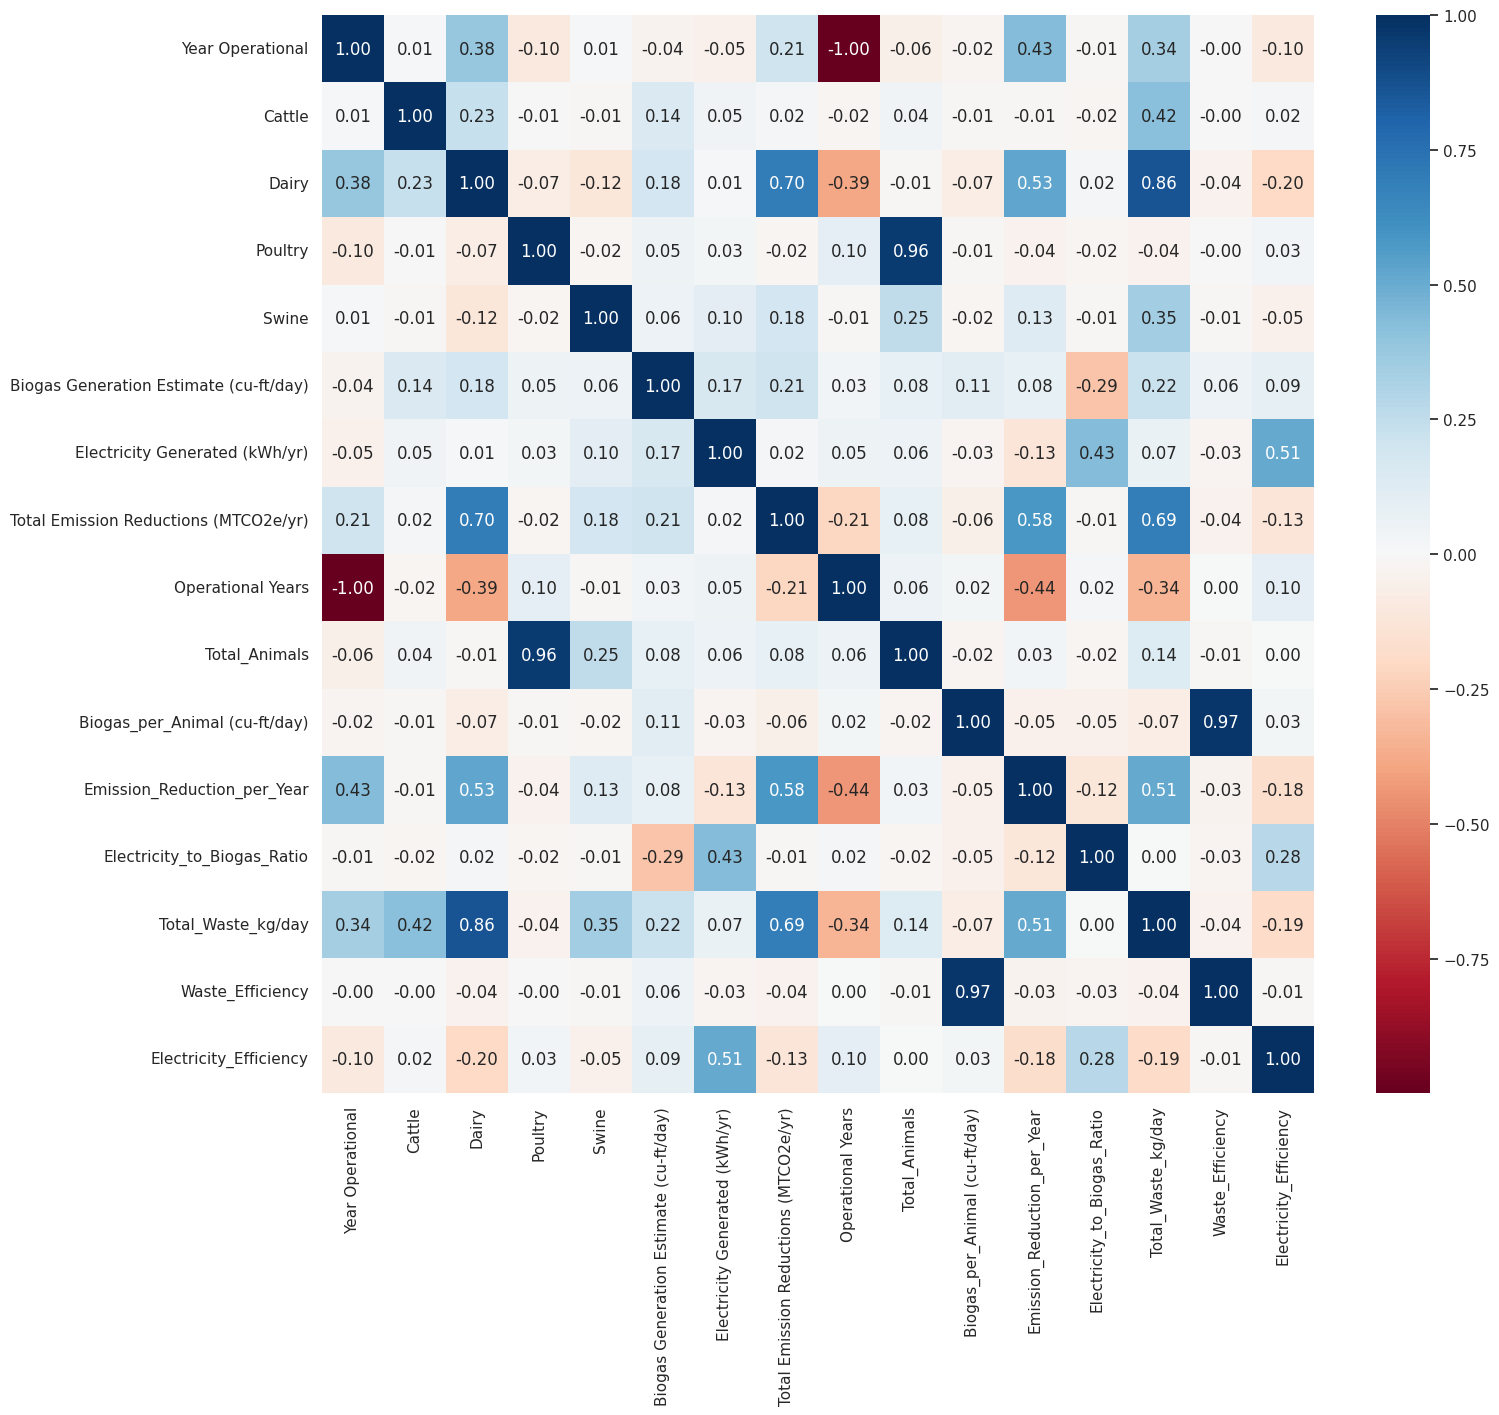

['Operational Years',
 'Total_Animals',
 'Total_Waste_kg/day',
 'Waste_Efficiency']

In [27]:
high_correlated_cols(df, plot=True)

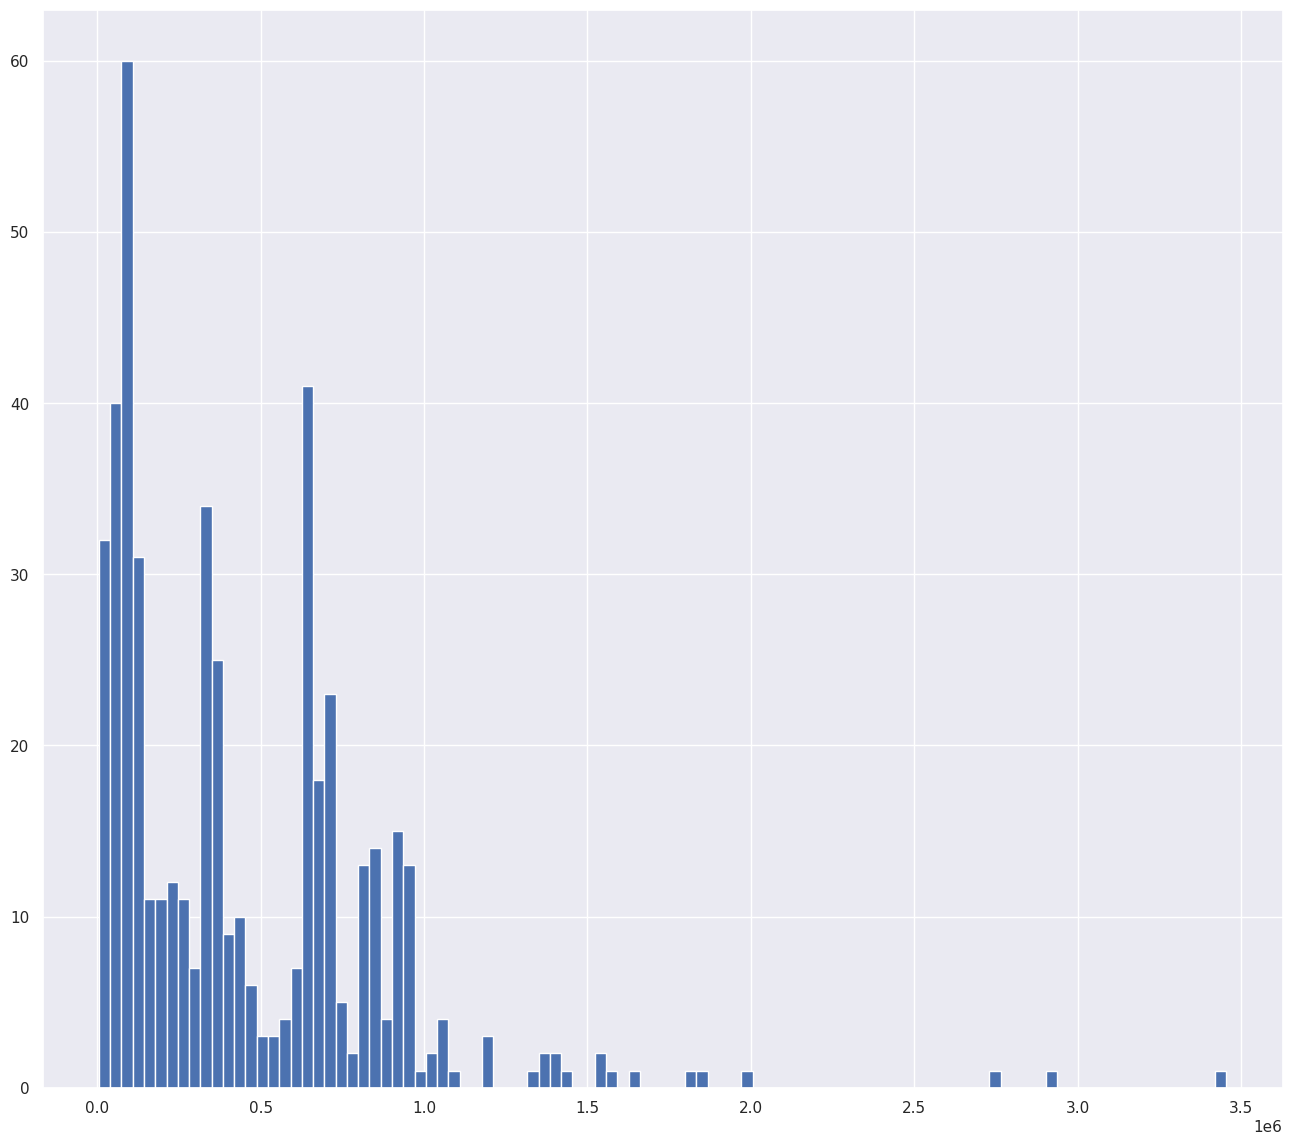

In [29]:
df["Biogas Generation Estimate (cu-ft/day)"].hist(bins=100)
plt.show(block=True)

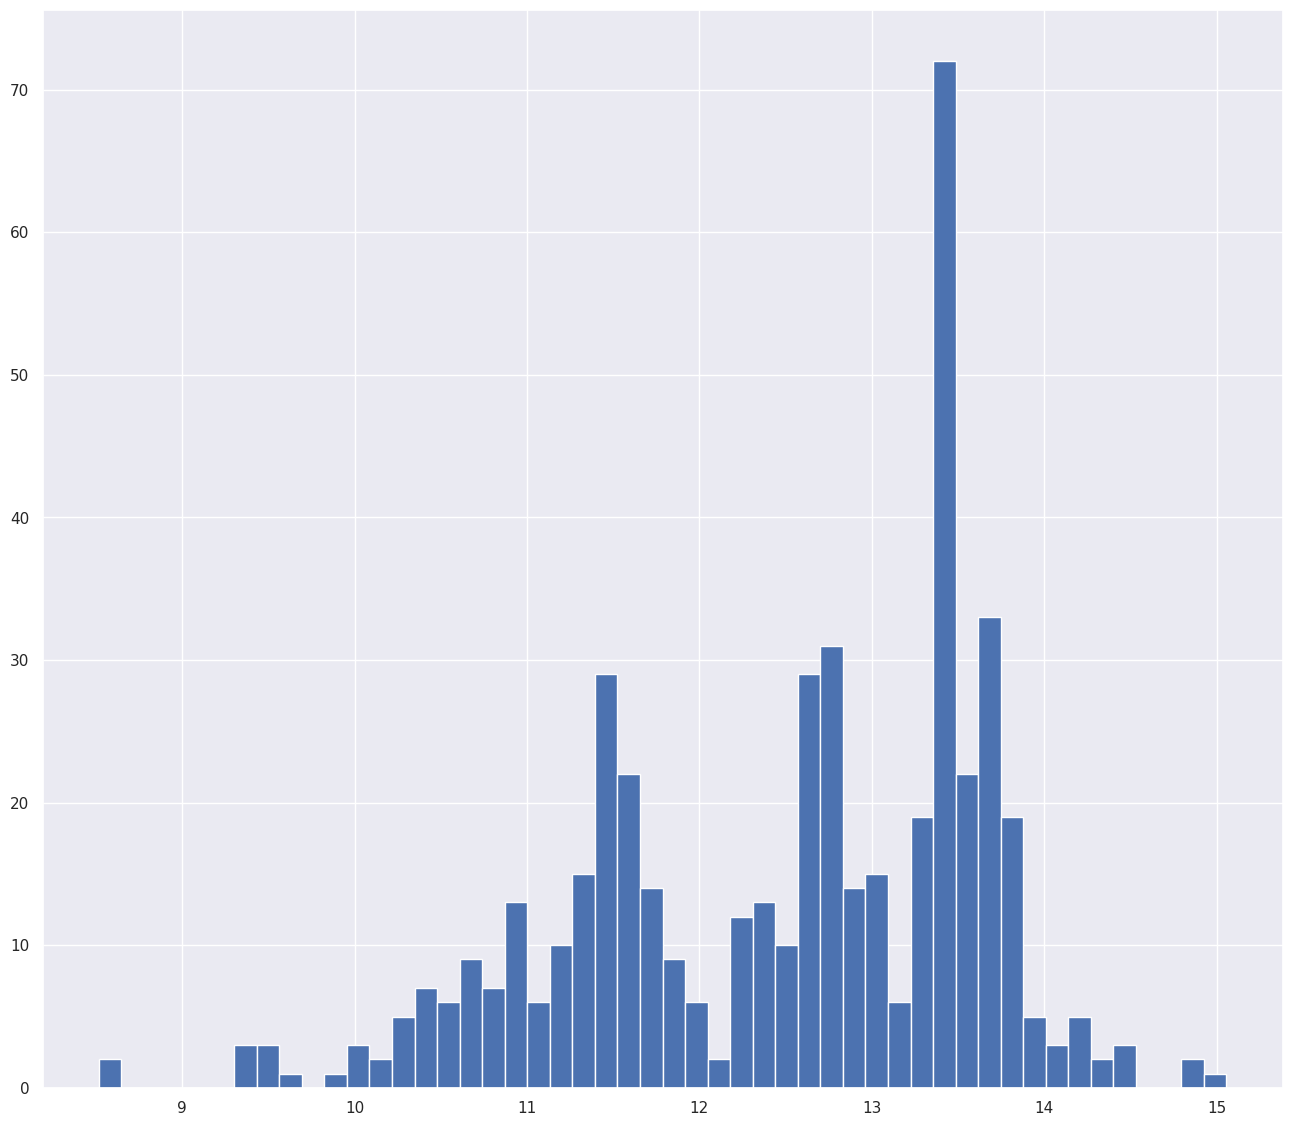

In [30]:
np.log1p(df['Biogas Generation Estimate (cu-ft/day)']).hist(bins=50)
plt.show(block=True)

In [31]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [32]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [33]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [34]:
for col in num_cols:
    print(col, check_outlier(df, col))

Year Operational True
Cattle True
Dairy True
Poultry True
Swine True
Biogas Generation Estimate (cu-ft/day) True
Electricity Generated (kWh/yr) True
Total Emission Reductions (MTCO2e/yr) True
Operational Years True
Total_Animals True
Biogas_per_Animal (cu-ft/day) True
Emission_Reduction_per_Year True
Electricity_to_Biogas_Ratio True
Total_Waste_kg/day True
Waste_Efficiency True
Electricity_Efficiency True


In [35]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [36]:
for col in num_cols:
    print(col, check_outlier(df, col))

Year Operational False
Cattle False
Dairy False
Poultry False
Swine False
Biogas Generation Estimate (cu-ft/day) False
Electricity Generated (kWh/yr) False
Total Emission Reductions (MTCO2e/yr) False
Operational Years False
Total_Animals False
Biogas_per_Animal (cu-ft/day) False
Emission_Reduction_per_Year False
Electricity_to_Biogas_Ratio False
Total_Waste_kg/day False
Waste_Efficiency False
Electricity_Efficiency False


In [37]:
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

In [38]:
missing_values_table(df)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []


In [39]:
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ':', len(dataframe[col].value_counts()))
        print(pd.DataFrame({'COUNT': dataframe[col].value_counts(),
                            'RATIO': dataframe[col].value_counts() / len(dataframe),
                            'TARGET_MEAN': dataframe.groupby(col)[target].mean()}), end='\n\n\n')

In [40]:
rare_analyser(df, "Biogas Generation Estimate (cu-ft/day)", cat_cols)

Project Type : 4
                        COUNT  RATIO  TARGET_MEAN
Project Type                                     
Centralized/Regional       16  0.033   628406.031
Farm Scale                449  0.914   425707.996
Multiple Farm/Facility     18  0.037   502957.267
Research                    8  0.016   241318.150


Digester Type : 14
                                                    COUNT  RATIO  TARGET_MEAN
Digester Type                                                                
Anaerobic Sequencing Batch Reactor                      3  0.006   673445.200
Complete Mix                                          127  0.259   441864.596
Complete Mix Mini Digester                              1  0.002   635485.200
Covered Lagoon                                        176  0.358   415514.593
Fixed Film/Attached Media                               7  0.014   614621.486
Horizontal Plug Flow                                   34  0.069   258600.088
Induced Blanket Reactor               

In [41]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
    return temp_df

In [42]:
rare_encoder(df, 0.01)

,Project Type,Digester Type,Status,Year Operational,Animal/Farm Type(s),Cattle,Dairy,Poultry,Swine,Co-Digestion,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Biogas End Use(s),LCFS Pathway?,Receiving Utility,Total Emission Reductions (MTCO2e/yr),Awarded USDA Funding?,Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency
0,Farm Scale,Covered Lagoon,Operational,2008.000,Swine,0.000,0.000,0.000,0.000,No-Info,1531339.150,0.000,Flared Full-time,No-Info,No-Info,4482.755,No-Info,15.000,4200.000,432.000,298.850,0.000,21000.000,20.797,0.000
1,Farm Scale,Mixed Plug Flow,Operational,2022.000,Dairy,0.000,11600.000,0.000,0.000,No-Info,109486.000,389698.200,Pipeline Gas,No-Info,Yes,14030.129,Yes,1.000,11760.000,9.310,14030.129,3.559,399840.000,0.274,0.975
2,Farm Scale,Unknown or Unspecified,Construction,2022.000,Dairy,0.000,8800.000,0.000,0.000,No-Info,94500.000,2813080.400,Pipeline Gas,No-Info,No-Info,98999.890,No-Info,1.000,8800.000,10.739,21493.914,29.768,299200.000,0.316,9.402
3,Centralized/Regional,Complete Mix,Operational,2018.000,Dairy,0.000,11600.000,0.000,0.000,No-Info,1531339.150,2760336.000,Pipeline Gas,No-Info,Yes,128996.899,No-Info,5.000,14450.000,115.150,21493.914,0.799,410252.500,3.387,2.706
4,Farm Scale,Complete Mix,Operational,2021.000,Dairy,0.000,10000.000,0.000,0.000,No-Info,852545.200,0.000,CNG,No-Info,Yes,100569.493,No-Info,2.000,10000.000,85.255,21493.914,0.000,340000.000,2.507,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,Farm Scale,Mixed Plug Flow,Shut down,2005.000,Dairy,0.000,1200.000,0.000,0.000,No-Info,356020.000,3350700.000,Cogeneration,No-Info,Yes,45346.437,Yes,18.000,1200.000,296.683,2519.246,9.412,40800.000,8.726,82.125
487,Farm Scale,Horizontal Plug Flow,Shut down,2002.000,Dairy,0.000,1000.000,0.000,0.000,No-Info,310865.600,946080.000,Electricity,No-Info,Yes,50391.122,No-Info,21.000,1000.000,310.866,2399.577,3.043,34000.000,9.143,27.826
488,Farm Scale,Fixed Film/Attached Media,Shut down,1999.000,Dairy,0.000,1800.000,0.000,0.000,No-Info,200000.000,5584500.000,Electricity; Boiler/Furnace fuel,No-Info,No-Info,46163.455,No-Info,24.000,1800.000,111.111,1923.477,27.922,61200.000,3.268,91.250
489,Farm Scale,Complete Mix,Shut down,2011.000,Dairy,0.000,200.000,0.000,0.000,Yes,23000.000,3206160.000,Electricity,No-Info,Yes,91464.825,No-Info,12.000,200.000,115.000,7622.069,31.119,6800.000,3.382,115.941


In [43]:
cat_cols, num_cols, cat_but_car,  num_but_cat = grab_col_names(df)

Observations: 491
Variables: 25
cat_cols: 12
num_cols: 13
cat_but_car: 0
num_but_cat: 3


In [44]:
cat_cols

['Project Type',
 'Digester Type',
 'Status',
 'Animal/Farm Type(s)',
 'Co-Digestion',
 'Biogas End Use(s)',
 'LCFS Pathway?',
 'Receiving Utility',
 'Awarded USDA Funding?',
 'Cattle',
 'Poultry',
 'Swine']

In [45]:
cat_cols = ['Project Type',
 'Digester Type',
 'Status',
 'Animal/Farm Type(s)',
 'Co-Digestion',
 'Biogas End Use(s)',
 'LCFS Pathway?',
 'Receiving Utility',
 'Awarded USDA Funding?']

In [46]:
cat_cols

['Project Type',
 'Digester Type',
 'Status',
 'Animal/Farm Type(s)',
 'Co-Digestion',
 'Biogas End Use(s)',
 'LCFS Pathway?',
 'Receiving Utility',
 'Awarded USDA Funding?']

In [47]:
num_cols

['Year Operational',
 'Dairy',
 'Biogas Generation Estimate (cu-ft/day)',
 'Electricity Generated (kWh/yr)',
 'Total Emission Reductions (MTCO2e/yr)',
 'Operational Years',
 'Total_Animals',
 'Biogas_per_Animal (cu-ft/day)',
 'Emission_Reduction_per_Year',
 'Electricity_to_Biogas_Ratio',
 'Total_Waste_kg/day',
 'Waste_Efficiency',
 'Electricity_Efficiency']

In [48]:
num_cols = ['Year Operational',
 'Dairy',
 'Biogas Generation Estimate (cu-ft/day)',
 'Electricity Generated (kWh/yr)',
 'Total Emission Reductions (MTCO2e/yr)',
 'Operational Years',
 'Total_Animals',
 'Biogas_per_Animal (cu-ft/day)',
 'Emission_Reduction_per_Year',
 'Electricity_to_Biogas_Ratio',
 'Total_Waste_kg/day',
 'Waste_Efficiency',
 'Electricity_Efficiency', 'Cattle',
 'Poultry',
 'Swine']

In [49]:
num_cols

['Year Operational',
 'Dairy',
 'Biogas Generation Estimate (cu-ft/day)',
 'Electricity Generated (kWh/yr)',
 'Total Emission Reductions (MTCO2e/yr)',
 'Operational Years',
 'Total_Animals',
 'Biogas_per_Animal (cu-ft/day)',
 'Emission_Reduction_per_Year',
 'Electricity_to_Biogas_Ratio',
 'Total_Waste_kg/day',
 'Waste_Efficiency',
 'Electricity_Efficiency',
 'Cattle',
 'Poultry',
 'Swine']

In [50]:
cat_but_car

[]

In [51]:
num_but_cat

['Cattle', 'Poultry', 'Swine']

In [52]:
num_but_cat =[]

In [53]:
num_but_cat

[]

In [54]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [55]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [56]:
df.head()

,Year Operational,Cattle,Dairy,Poultry,Swine,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Total Emission Reductions (MTCO2e/yr),Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency,Project Type_Farm Scale,Project Type_Multiple Farm/Facility,Project Type_Research,Digester Type_Complete Mix,Digester Type_Complete Mix Mini Digester,Digester Type_Covered Lagoon,Digester Type_Fixed Film/Attached Media,Digester Type_Horizontal Plug Flow,Digester Type_Induced Blanket Reactor,Digester Type_Mixed Plug Flow,Digester Type_Modular Plug Flow,Digester Type_No-Info,Digester Type_Plug Flow - Unspecified,Digester Type_Primary digester tank with secondary covered lagoon,Digester Type_Unknown or Unspecified,Digester Type_Vertical Plug Flow,Status_Operational,Status_Shut down,Animal/Farm Type(s)_Cattle; Dairy,Animal/Farm Type(s)_Cattle; Poultry,Animal/Farm Type(s)_Cattle; Swine,Animal/Farm Type(s)_Dairy,Animal/Farm Type(s)_Dairy; Poultry; Swine,Animal/Farm Type(s)_Dairy; Swine,Animal/Farm Type(s)_Poultry,Animal/Farm Type(s)_Swine,Co-Digestion_Yes,Biogas End Use(s)_Boiler/Furnace fuel; CNG,Biogas End Use(s)_CNG,Biogas End Use(s)_Cogeneration,Biogas End Use(s)_Cogeneration; Boiler/Furnace fuel,Biogas End Use(s)_Cogeneration; CNG,Biogas End Use(s)_Cogeneration; Pipeline Gas,Biogas End Use(s)_Cogeneration; Refrigeration,Biogas End Use(s)_Electricity,Biogas End Use(s)_Electricity; Boiler/Furnace fuel,Biogas End Use(s)_Electricity; Boiler/Furnace fuel; CNG,Biogas End Use(s)_Electricity; CNG,Biogas End Use(s)_Electricity; Cogeneration,Biogas End Use(s)_Electricity; Cogeneration; Boiler/Furnace fuel,Biogas End Use(s)_Electricity; Pipeline Gas,Biogas End Use(s)_Flared Full-time,Biogas End Use(s)_No-Info,Biogas End Use(s)_Pipeline Gas,Biogas End Use(s)_Pipeline to Electricity,LCFS Pathway?_Yes,Receiving Utility_Yes,Awarded USDA Funding?_Yes
0,2008.000,0.000,0.000,0.000,0.000,1531339.150,0.000,4482.755,15.000,4200.000,432.000,298.850,0.000,21000.000,20.797,0.000,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,2022.000,0.000,11600.000,0.000,0.000,109486.000,389698.200,14030.129,1.000,11760.000,9.310,14030.129,3.559,399840.000,0.274,0.975,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
2,2022.000,0.000,8800.000,0.000,0.000,94500.000,2813080.400,98999.890,1.000,8800.000,10.739,21493.914,29.768,299200.000,0.316,9.402,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,2018.000,0.000,11600.000,0.000,0.000,1531339.150,2760336.000,128996.899,5.000,14450.000,115.150,21493.914,0.799,410252.500,3.387,2.706,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4,2021.000,0.000,10000.000,0.000,0.000,852545.200,0.000,100569.493,2.000,10000.000,85.255,21493.914,0.000,340000.000,2.507,0.000,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,F

In [57]:
num_cols = [col for col in num_cols if col not in ["Biogas Generation Estimate (cu-ft/day)"]]

In [58]:
scaler = RobustScaler()

In [59]:
df[num_cols] = scaler.fit_transform(df[num_cols])

In [60]:
df.head(10)

,Year Operational,Cattle,Dairy,Poultry,Swine,Biogas Generation Estimate (cu-ft/day),Electricity Generated (kWh/yr),Total Emission Reductions (MTCO2e/yr),Operational Years,Total_Animals,Biogas_per_Animal (cu-ft/day),Emission_Reduction_per_Year,Electricity_to_Biogas_Ratio,Total_Waste_kg/day,Waste_Efficiency,Electricity_Efficiency,Project Type_Farm Scale,Project Type_Multiple Farm/Facility,Project Type_Research,Digester Type_Complete Mix,Digester Type_Complete Mix Mini Digester,Digester Type_Covered Lagoon,Digester Type_Fixed Film/Attached Media,Digester Type_Horizontal Plug Flow,Digester Type_Induced Blanket Reactor,Digester Type_Mixed Plug Flow,Digester Type_Modular Plug Flow,Digester Type_No-Info,Digester Type_Plug Flow - Unspecified,Digester Type_Primary digester tank with secondary covered lagoon,Digester Type_Unknown or Unspecified,Digester Type_Vertical Plug Flow,Status_Operational,Status_Shut down,Animal/Farm Type(s)_Cattle; Dairy,Animal/Farm Type(s)_Cattle; Poultry,Animal/Farm Type(s)_Cattle; Swine,Animal/Farm Type(s)_Dairy,Animal/Farm Type(s)_Dairy; Poultry; Swine,Animal/Farm Type(s)_Dairy; Swine,Animal/Farm Type(s)_Poultry,Animal/Farm Type(s)_Swine,Co-Digestion_Yes,Biogas End Use(s)_Boiler/Furnace fuel; CNG,Biogas End Use(s)_CNG,Biogas End Use(s)_Cogeneration,Biogas End Use(s)_Cogeneration; Boiler/Furnace fuel,Biogas End Use(s)_Cogeneration; CNG,Biogas End Use(s)_Cogeneration; Pipeline Gas,Biogas End Use(s)_Cogeneration; Refrigeration,Biogas End Use(s)_Electricity,Biogas End Use(s)_Electricity; Boiler/Furnace fuel,Biogas End Use(s)_Electricity; Boiler/Furnace fuel; CNG,Biogas End Use(s)_Electricity; CNG,Biogas End Use(s)_Electricity; Cogeneration,Biogas End Use(s)_Electricity; Cogeneration; Boiler/Furnace fuel,Biogas End Use(s)_Electricity; Pipeline Gas,Biogas End Use(s)_Flared Full-time,Biogas End Use(s)_No-Info,Biogas End Use(s)_Pipeline Gas,Biogas End Use(s)_Pipeline to Electricity,LCFS Pathway?_Yes,Receiving Utility_Yes,Awarded USDA Funding?_Yes
0,-0.286,0.000,-0.455,0.000,0.000,1531339.150,-0.254,-0.406,0.286,0.197,2.249,-0.166,-0.321,-0.365,2.342,-0.389,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0.714,0.000,2.182,0.000,0.000,109486.000,-0.123,-0.208,-0.714,1.623,-0.419,1.464,-0.035,2.129,-0.312,-0.368,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
2,0.714,0.000,1.545,0.000,0.000,94500.000,0.691,1.549,-0.714,1.065,-0.410,2.349,2.070,1.466,-0.307,-0.186,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,0.429,0.000,2.182,0.000,0.000,1531339.150,0.673,2.169,-0.429,2.131,0.249,2.349,-0.257,2.198,0.090,-0.330,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0.643,0.000,1.818,0.000,0.000,852545.200,-0.254,1.582,-0.643,1.291,0.061,2.349,-0.321,1.735,-0.023,-0.389,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
5,-0.071,0.000,2.182,0.000,0.000,663685.200,1.512,2.

In [61]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('[^A-Za-z0-9_]+', '', regex=True)
df.columns = df.columns.str.lower()


In [62]:
df.head()

,year_operational,cattle,dairy,poultry,swine,biogas_generation_estimate_cuftday,electricity_generated_kwhyr,total_emission_reductions_mtco2eyr,operational_years,total_animals,biogas_per_animal_cuftday,emission_reduction_per_year,electricity_to_biogas_ratio,total_waste_kgday,waste_efficiency,electricity_efficiency,project_type_farm_scale,project_type_multiple_farmfacility,project_type_research,digester_type_complete_mix,digester_type_complete_mix_mini_digester,digester_type_covered_lagoon,digester_type_fixed_filmattached_media,digester_type_horizontal_plug_flow,digester_type_induced_blanket_reactor,digester_type_mixed_plug_flow,digester_type_modular_plug_flow,digester_type_noinfo,digester_type_plug_flow__unspecified,digester_type_primary_digester_tank_with_secondary_covered_lagoon,digester_type_unknown_or_unspecified,digester_type_vertical_plug_flow,status_operational,status_shut_down,animalfarm_types_cattle_dairy,animalfarm_types_cattle_poultry,animalfarm_types_cattle_swine,animalfarm_types_dairy,animalfarm_types_dairy_poultry_swine,animalfarm_types_dairy_swine,animalfarm_types_poultry,animalfarm_types_swine,codigestion_yes,biogas_end_uses_boilerfurnace_fuel_cng,biogas_end_uses_cng,biogas_end_uses_cogeneration,biogas_end_uses_cogeneration_boilerfurnace_fuel,biogas_end_uses_cogeneration_cng,biogas_end_uses_cogeneration_pipeline_gas,biogas_end_uses_cogeneration_refrigeration,biogas_end_uses_electricity,biogas_end_uses_electricity_boilerfurnace_fuel,biogas_end_uses_electricity_boilerfurnace_fuel_cng,biogas_end_uses_electricity_cng,biogas_end_uses_electricity_cogeneration,biogas_end_uses_electricity_cogeneration_boilerfurnace_fuel,biogas_end_uses_electricity_pipeline_gas,biogas_end_uses_flared_fulltime,biogas_end_uses_noinfo,biogas_end_uses_pipeline_gas,biogas_end_uses_pipeline_to_electricity,lcfs_pathway_yes,receiving_utility_yes,awarded_usda_funding_yes
0,-0.286,0.000,-0.455,0.000,0.000,1531339.150,-0.254,-0.406,0.286,0.197,2.249,-0.166,-0.321,-0.365,2.342,-0.389,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,0.714,0.000,2.182,0.000,0.000,109486.000,-0.123,-0.208,-0.714,1.623,-0.419,1.464,-0.035,2.129,-0.312,-0.368,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True
2,0.714,0.000,1.545,0.000,0.000,94500.000,0.691,1.549,-0.714,1.065,-0.410,2.349,2.070,1.466,-0.307,-0.186,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,0.429,0.000,2.182,0.000,0.000,1531339.150,0.673,2.169,-0.429,2.131,0.249,2.349,-0.257,2.198,0.090,-0.330,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False
4,0.643,0.000,1.818,0.000,0.000,852545.200,-0.254,1.582,-0.643,1.291,0.061,2.349,-0.321,1.735,-0.023,-0.389,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [63]:
y = df["biogas_generation_estimate_cuftday"]

In [64]:
X = df.drop(["biogas_generation_estimate_cuftday"], axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

In [66]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          ("CatBoost", CatBoostRegressor(verbose=False))]

# Initialize empty lists to store metrics and execution times
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []
model_names = []

# Main loop to fit, predict, and evaluate each model
for name, regressor in models:
    start_time = time.time()

    # Fit the model
    regressor.fit(X_train, y_train)

    # Make predictions
    y_pred = regressor.predict(X_test)

    # Calculate RMSE
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)

    # Calculate R^2 score
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)

    # Calculate MAE
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    # Calculate MSE
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate the execution time of the model
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    # Store model name
    model_names.append(name)

# Create a DataFrame to hold all the metrics and execution times
results_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R^2 Score': r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'Execution Time (s)': execution_times
})

results_df

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.618e+12, tolerance: 5.178e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.729e+12, tolerance: 5.255e+09
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.662e+12, tolerance: 5.355e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 29
[LightGBM] [Info] Start training from score 431417.266950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Model,RMSE,R^2 Score,MAE,MSE,Execution Time (s)
0,LR,65594037525806512.000,-169843774178677088.000,14554974331461.822,20972880037872639335282507776.000,0.139
1,Ridge,231750.901,0.747,132592.223,31280956974.504,0.146
2,Lasso,242434.712,0.713,139389.467,35380801538.147,0.286
3,ElasticNet,235494.705,0.620,161574.322,46977622019.240,0.123
4,KNN,260844.350,0.669,129857.988,40835759366.322,0.187
5,CART,243419.676,0.674,89649.129,40306911226.926,0.081
6,RF,162383.238,0.842,74994.280,19563514045.949,3.709
7,GBM,161191.215,0.841,79256.571,19579768541.008,1.263
8,XGBoost,169478.334,0.839,71466.528,19892400207.489,1.760
9,LightGBM,157380.438,0.893,69483.594,13187941025.913,0.651


In [67]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initialize lists to store metrics
rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []
model_names = []

# Define the hyperparameters for each model

param_grids = {
    'LR': {},
    'Ridge': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'ElasticNet': {'alpha': [0.01, 0.1, 1.0, 10.0, 100.0], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'KNN': {'n_neighbors': [1, 3, 5, 7, 9]},
    'CART': {'max_depth': [None, 5, 10, 20, 30], 'min_samples_leaf': [1, 2, 3]},
    'RF': {'n_estimators': [10, 30, 50, 70, 100], 'max_depth': [None, 5, 10, 20]},
    'GBM': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    'XGBoost': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    'LightGBM': {'n_estimators': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1]},
    'CatBoost': {'iterations': [10, 30, 50, 70, 100], 'learning_rate': [0.005, 0.01, 0.05, 0.1], 'depth': [3, 4, 5, 6, 7]}
}

# Variables to store best model and score globally
best_global_score = np.inf
best_global_model = None

# Main loop to fit, predict, and evaluate each model
for name, regressor in models:
    start_time = time.time()

    # Hyperparameter tuning with GridSearchCV if param_grids is defined
    if param_grids.get(name):
        grid_search = GridSearchCV(regressor, param_grid=param_grids[name], cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = regressor
        best_model.fit(X_train, y_train)

    # Make predictions
    y_pred = best_model.predict(X_test)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

    # Update best global model and score
    if rmse < best_global_score:
        best_global_score = rmse
        best_global_model = best_model

    # Calculate other metrics
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

    mae = mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)

    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    # Calculate execution time
    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    # Store model name
    model_names.append(name)

# Create a DataFrame to store all the metrics and execution times
results_with_tuning_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R^2 Score': r2_scores,
    'MAE': mae_scores,
    'MSE': mse_scores,
    'Execution Time (s)': execution_times
})

results_with_tuning_df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1037
[LightGBM] [Info] Number of data points in the train set: 392, number of used features: 29
[LightGBM] [Info] Start training from score 431417.266950
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,Model,RMSE,R^2 Score,MAE,MSE,Execution Time (s)
0,LR,144820164472605.938,-169843774178677088.000,14554974331461.822,20972880037872639335282507776.000,0.014
1,Ridge,178371.621,0.742,129995.152,31816435060.615,3.180
2,Lasso,183154.932,0.728,136611.920,33545729215.066,0.685
3,ElasticNet,181445.583,0.733,130741.658,32922499709.238,1.804
4,KNN,202078.597,0.669,129857.988,40835759366.322,0.386
5,CART,174151.506,0.754,91689.835,30328747154.477,0.886
6,RF,136243.466,0.850,73450.135,18562282014.992,17.571
7,GBM,141888.035,0.837,79915.862,20132214363.055,10.070
8,XGBoost,132823.131,0.857,70625.816,17641984166.206,16.580
9,LightGBM,114838.761,0.893,69483.594,13187941025.913,6.036


In [68]:
best_global_model

LGBMRegressor()

In [69]:
final_model = best_global_model

# Make predictions on the test set using the final model
y_final_pred = final_model.predict(X_test)
final_y_pred = (y_final_pred)
final_y_test =(y_test)

In [70]:
results = pd.DataFrame({'Predicted Value': final_y_pred, 'True Value': final_y_test})

# Calculate the difference between the true prices and predicted prices and add a new column
results['Difference'] = results['True Value'] - results['Predicted Value']

# Display the first 5 rows
print("First 5 rows:")
print(results.head())

# Display the last 5 rows
print("\nLast 5 rows:")
print(results.tail())

First 5 rows:
     Predicted Value  True Value  Difference
459       958055.176 1067732.000  109676.824
404       824770.305  635485.200 -189285.105
14        930764.487 1016945.200   86180.713
482      1263130.435 1452172.000  189041.565
366        95143.818   87948.000   -7195.818

Last 5 rows:
     Predicted Value  True Value  Difference
20         20282.854   94500.000   74217.146
51        200620.043  200000.000    -620.043
68        326966.172  325000.000   -1966.172
411        87785.562   44193.000  -43592.562
167       481736.372  450000.000  -31736.372


In [71]:

from joblib import dump

dump(final_model, 'catboost_model.joblib')

['catboost_model.joblib']